In [1]:
from scipy.special import softmax
from transformers import GPT2Model, GPT2LMHeadModel, GPT2TokenizerFast
import matplotlib.pyplot as plt
import numpy as np
import torch
from make_sents import *

### MATPLOTLIB FORMATTING ###
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

workflow:
1) process replaced sentences for their three metrics
2) process the orig sentences for their three metrics 
3) plot in three graphs maybe in a line plot? — differences in replaced v.s. differences in orig

In [2]:
gpt = GPT2Model.from_pretrained("gpt2")
gptlmh = GPT2LMHeadModel.from_pretrained("gpt2")
gpttokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpttokenizer.padding_side = "right"
gpttokenizer.pad_token = gpttokenizer.eos_token 
gpt.config.pad_token_id = gpt.config.eos_token_id 
gpt.eval();

def embed(tokenizer, model, sentence, output_hidden_states=True):
    """Given a model and a tokenizer embed() will return embeddings for each token in sentence. You can 
    return the attention matrices and the full hidden state dictionaries if desired."""

    model.eval()
    tokens_tensor = tokenizer(sentence, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(tokens_tensor))

    with torch.no_grad():
        outputs = model(tokens_tensor, output_hidden_states=output_hidden_states)
        loss = outputs[0]
        last_layer = outputs.hidden_states[-1]
        

    return np.squeeze(last_layer), tokens

$$Manhattan Distance$$

In [3]:
def distance_track(primed, unprimed, postfix, tokenizer, model, p=1):
    coords, tokens = embed(tokenizer, model, primed)
    _coords, _tokens = embed(tokenizer, model, unprimed) #underscore means its been tampered, doesn't have GP effect

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    post_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(post_tokens_tensor))
    aft = len(post_tokens)
    __coords = []
    j = 0
    for i in range(len(_tokens)):
        if _tokens[i] == tokens[j]:
            j += 1
            __coords.append(_coords[i].cpu().detach().numpy())
            
    __coords = np.array(__coords)
    coords = coords.cpu().detach().numpy()
    dists = np.sum(np.abs(__coords - coords), axis=1)
    diffs = __coords - coords
    
    mn = np.mean(np.concatenate((__coords, coords), axis=0), axis=0)
    __normed = np.subtract(__coords, mn)
    normed = np.subtract(coords, mn)
    sims = (__normed * normed).sum(axis=1)/(np.linalg.norm(__normed, axis=1)*np.linalg.norm(normed, axis=1))
    cutoff = len(dists) - aft
    return dists, sims, diffs, cutoff

def distance_tracks(get_components, kwargs, tokenizer, model):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _, subj_ind = get_components(**kwargs)
    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    dists = []
    sims = []
    diffs = []
    cutoffs = []
    for i in range(n):
        dist, sim, diff, cutoff = distance_track(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, model)
        dists.append(dist)
        sims.append(sim)
        diffs.append(diff)
        cutoffs.append(cutoff)

    return dists, sims, diffs, cutoffs

$$Surprisal$$

In [4]:
def surprisal_track(primed, unprimed, postfix, tokenizer, lmhmodel):
    lmhmodel.eval()
    print(primed)
    print(unprimed)

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    aft = len(post_tokens_tensor[0])

    sent_tokens = tokenizer.tokenize(primed)
    indexed_tokens = tokenizer.convert_tokens_to_ids(sent_tokens)
    # create 1 * T input token tensor
    tokens_tensor = torch.tensor(indexed_tokens).unsqueeze(0)
    
    _sent_tokens = tokenizer.tokenize(unprimed)
    _indexed_tokens = tokenizer.convert_tokens_to_ids(_sent_tokens)
    # create 1 * T input token tensor
    _tokens_tensor = torch.tensor(_indexed_tokens).unsqueeze(0)
    with torch.no_grad():
        outputs = lmhmodel(tokens_tensor)
        _outputs = lmhmodel(_tokens_tensor)


    logprobs = outputs[0].log_softmax(dim=2).squeeze()
    _logprobs = _outputs[0].log_softmax(dim=2).squeeze()
    predictions = list(zip(sent_tokens, indexed_tokens, (None,) + logprobs.unbind()))
    _predictions = list(zip(_sent_tokens, _indexed_tokens, (None,) + _logprobs.unbind()))
    
    surprisals = []
    for word, word_idx, preds in predictions:
        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        surprisals.append((word, word_idx, surprisal))

    _surprisals = []
    i = 0
    for word, word_idx, preds in _predictions:
        if word == predictions[i][0]:
            i += 1
        else:
            continue

        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        _surprisals.append((word, word_idx, surprisal))

    assert len(surprisals) == len(_surprisals)
    return [surprisals[i][-1] - _surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft

def surprisal_tracks(get_components, kwargs, tokenizer, lmhmodel):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _, subj_ind = get_components(**kwargs)

    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    surprisal_diffs = []
    cutoffs = []
    for i in range(n):
        diff, cutoff = surprisal_track(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, lmhmodel)
        surprisal_diffs.append(diff)
        cutoffs.append(cutoff)
    
    return surprisal_diffs, cutoffs

## 1-1 GPT orig

In [5]:
# create df to store dists, sims, diffs, cutoffs

npz_orig_results = {}
nps_orig_results = {}
va_orig_results = {}


In [6]:
gp_types = ['npz', 'nps', 'va']

for gp_type in gp_types:
    if gp_type == 'npz':
        print('---NPZ---')
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'comma':False}
        dists, sims, diffs, cutoffs = distance_tracks(get_components_npz, kwargs, gpttokenizer, gpt)
        npz_orig_results = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'comma':False}
        surps, cutoffs = surprisal_tracks(get_components_npz, kwargs, gpttokenizer, gptlmh)
        npz_orig_results['surps'] = surps
        npz_orig_results['surps_cutoffs'] = cutoffs

    elif gp_type == 'nps':
        print('---NPS---')
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'that':False}
        dists, sims, diffs, cutoffs = distance_tracks(get_components_nps, kwargs, gpttokenizer, gpt)
        nps_orig_results = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'that':False}
        surps, cutoffs = surprisal_tracks(get_components_nps, kwargs, gpttokenizer, gptlmh)
        nps_orig_results['surps'] = surps
        nps_orig_results['surps_cutoffs'] = cutoffs

    elif gp_type == 'va':
        print('---va---')
        kwargs = {'sent_type':'gp', 'intervener':True, 'unreduced':False}
        dists, sims, diffs, cutoffs = distance_tracks(get_components_va, kwargs, gpttokenizer, gpt)
        va_orig_results = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type':'gp', 'intervener':True, 'unreduced':False}
        surps, cutoffs = surprisal_tracks(get_components_va, kwargs, gpttokenizer, gptlmh)
        va_orig_results['surps'] = surps
        va_orig_results['surps_cutoffs'] = cutoffs

---NPZ---
including columns: ['Start', 'Context', 'Transitive Verb', 'NP/Z', 'Extension', 'Verb', 'Rest']
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
including columns: ['Start', 'Context', 'Transitive Verb', 'NP/Z', 'Extension', 'Verb', 'Rest']
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
As the gangster who killed for money shot the woman with her young daughters burst into hysterics.
As the gangster who killed for money shot, the woman with her young daughters burst into hysterics.
When the dog with the black spot on his eye scratched the vet who was attending to him took off the muzzle.
When the dog with the black spot on his eye scratched, the vet who was attending to him took off the muzzle.
As the ship loaded with spices sailed the waters of the Atlantic Ocean remained blue and calm.
As the ship loaded with spices sailed, the waters of the Atlantic Ocean remai

In case the team which fired their coach lost the tie-breaker for the conference title was scheduled for the following week at the local park.
In case the team which fired their coach lost, the tie-breaker for the conference title was scheduled for the following week at the local park.
After the librarian who supervised the staff called the intern who was brand new began returning boooks to the shelves.
After the librarian who supervised the staff called, the intern who was brand new began returning boooks to the shelves.
Even though the army which guarded the border surrendered the territory they had been fighting over was filled with land mines that still had to be cleared.
Even though the army which guarded the border surrendered, the territory they had been fighting over was filled with land mines that still had to be cleared.
While the narrator who caught a cold read the story that had touched so many lives was dramatized by the troupe of skilled actors.
While the narrator who cau

The prisoners pounded for hours and hours in the morning confessed to crimes they never committed.
The prisoners who were pounded for hours and hours in the morning confessed to crimes they never committed.
The business expanded into an empire spanning multiple countries was sold for billions of dollars.
The business that was expanded into an empire spanning multiple countries was sold for billions of dollars.
The rats consumed rapidly and entirely due to great hunger were digested in the belly of the cat.
The rats that were consumed rapidly and entirely due to great hunger were digested in the belly of the cat.
The lawyer pledged to complete secrecy due to security issues was discovered to have broken his promise.
The lawyer that was pledged to complete secrecy due to security issues was discovered to have broken his promise.
The child neglected in the chaos of the war found her way back home.
The child who was neglected in the chaos of the war found her way back home.
The horses race

In [7]:
npz_orig_results = pd.DataFrame(npz_orig_results)
nps_orig_results = pd.DataFrame(nps_orig_results)
va_orig_results = pd.DataFrame(va_orig_results)
npz_orig_results.to_excel('npz_orig_results.xlsx', index=False)
nps_orig_results.to_excel('nps_orig_results.xlsx', index=False)
va_orig_results.to_excel('va_orig_results.xlsx', index=False)


## 1-2 GPT replaced

In [8]:
# create df to store dists, sims, diffs, cutoffs

npz_replaced_results = {}
nps_replaced_results = {}
va_replaced_results = {}

In [9]:
def distance_track_rep(primed, unprimed, postfix, tokenizer, model, subj_ind, p=1):
    subj_word = primed.split()[subj_ind]
    _subj_word = unprimed.split()[subj_ind]
    
    subj_tokens_tensor = tokenizer(' '.join(primed.split()[:subj_ind+1]), return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    subj_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(subj_tokens_tensor))
    _subj_tokens_tensor = tokenizer(' '.join(unprimed.split()[:subj_ind+1]), return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    _subj_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(_subj_tokens_tensor))
    
    
    coords, tokens = embed(tokenizer, model, primed)
    _coords, _tokens = embed(tokenizer, model, unprimed) #underscore means its been tampered, doesn't have GP effect

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    post_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(post_tokens_tensor))
    aft = len(post_tokens)
    __coords = []
    j = 0
    i = 0
    if len(subj_tokens) < len(_subj_tokens):
        while i < len(_tokens):
            if _tokens[i]  == _subj_tokens[subj_ind]:
                j += len(_subj_tokens) - subj_ind - 1
                __coords.append(np.mean(_coords[i:i + len(_subj_tokens) - subj_ind].cpu().detach().numpy(), axis=0))
                i += len(_subj_tokens) - subj_ind - 1
            elif _tokens[i] == tokens[j]:
                j += 1
                __coords.append(_coords[i].cpu().detach().numpy())
            i += 1 
            
    elif len(subj_tokens) == len(_subj_tokens):
        __coords = _coords.cpu().detach().numpy()
    else:
        while i < len(_tokens):
            if _tokens[i] == _subj_tokens[subj_ind]:
                j += len(subj_tokens) - subj_ind 
                new_subj_coords = np.sum(_coords[i:i + len(_subj_tokens) - subj_ind].cpu().detach().numpy(), axis=0) / len(subj_tokens)
                for x in range(len(subj_tokens) - subj_ind):
                    __coords.append(new_subj_coords)
                i += len(_subj_tokens)- subj_ind - 1
            elif _tokens[i] == tokens[j]:
                j += 1
                __coords.append(_coords[i].cpu().detach().numpy())
            i += 1 
    coords = coords.cpu().detach().numpy()
    dists = np.sum(np.abs(__coords - coords), axis=1)
    diffs = __coords - coords
    mn = np.mean(np.concatenate((__coords, coords), axis=0), axis=0)
    __normed = np.subtract(__coords, mn)
    normed = np.subtract(coords, mn)
    sims = (__normed * normed).sum(axis=1)/(np.linalg.norm(__normed, axis=1)*np.linalg.norm(normed, axis=1))
    cutoff = len(dists) - aft
    return dists, sims, diffs, cutoff


def distance_tracks_rep(get_components, kwargs, tokenizer, model):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    assert 'filename' in kwargs
    kwargs['filename'] = kwargs['filename'][:-9]
    print('kwargs[filename]', kwargs['filename'])
    _pre, _, _subj_ind = get_components(**kwargs)
    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    dists = []
    sims = []
    diffs = []
    cutoffs = []
    for i in range(n):
        dist, sim, diff, cutoff = distance_track_rep(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, model, subj_ind[i])
        dists.append(dist)
        sims.append(sim)
        diffs.append(diff)
        cutoffs.append(cutoff)

    return dists, sims, diffs, cutoffs
def surprisal_track_rep(primed, unprimed, postfix, tokenizer, lmhmodel):
    lmhmodel.eval()
    print(primed)
    print(unprimed)

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    aft = len(post_tokens_tensor[0])

    sent_tokens = tokenizer.tokenize(primed)
    indexed_tokens = tokenizer.convert_tokens_to_ids(sent_tokens)
    # create 1 * T input token tensor
    tokens_tensor = torch.tensor(indexed_tokens).unsqueeze(0)
    
    _sent_tokens = tokenizer.tokenize(unprimed)
    _indexed_tokens = tokenizer.convert_tokens_to_ids(_sent_tokens)
    # create 1 * T input token tensor
    _tokens_tensor = torch.tensor(_indexed_tokens).unsqueeze(0)
    with torch.no_grad():
        outputs = lmhmodel(tokens_tensor)
        _outputs = lmhmodel(_tokens_tensor)


    logprobs = outputs[0].log_softmax(dim=2).squeeze()
    _logprobs = _outputs[0].log_softmax(dim=2).squeeze()
    predictions = list(zip(sent_tokens, indexed_tokens, (None,) + logprobs.unbind()))
    _predictions = list(zip(_sent_tokens, _indexed_tokens, (None,) + _logprobs.unbind()))
    
    surprisals = []
    for word, word_idx, preds in predictions:
        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        surprisals.append((word, word_idx, surprisal))

    _surprisals = []
    i = 0
    for word, word_idx, preds in _predictions:
        if word == predictions[i][0]:
            i += 1
        else:
            continue

        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        _surprisals.append((word, word_idx, surprisal))

    assert len(surprisals) == len(_surprisals)
    return [surprisals[i][-1] - _surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft

def surprisal_tracks_rep(get_components, kwargs, tokenizer, lmhmodel):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    assert 'filename' in kwargs
    kwargs['filename'] = kwargs['filename'][:-9]
    print('kwargs[filename]', kwargs['filename'])
    _pre, _, subj_ind = get_components(**kwargs)

    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    surprisal_diffs = []
    cutoffs = []
    for i in range(n):
        diff, cutoff = surprisal_track_rep(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, lmhmodel)
        surprisal_diffs.append(diff)
        cutoffs.append(cutoff)
    
    return surprisal_diffs, cutoffs

In [10]:
gp_types = ['npz', 'nps', 'va']

for gp_type in gp_types:
    if gp_type == 'npz':
        print('---NPZ---')
        kwargs = {'filename':'npz_replaced', 'sent_type': 'gp', 'context':True, 'extension':True, 'comma':True}
        dists, sims, diffs, cutoffs = distance_tracks_rep(get_components_npz, kwargs, gpttokenizer, gpt)
        npz_replaced_results = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }

    elif gp_type == 'nps':
        print('---NPS---')
        kwargs = {'filename':'nps_replaced','sent_type': 'gp', 'context':True, 'extension':True, 'that':True}
        dists, sims, diffs, cutoffs = distance_tracks_rep(get_components_nps, kwargs, gpttokenizer, gpt)
        nps_replaced_results = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }

    elif gp_type == 'va':
        print('---va---')
        kwargs = {'filename':'vawip_replaced','sent_type':'gp', 'intervener':True, 'unreduced':True}
        dists, sims, diffs, cutoffs = distance_tracks_rep(get_components_va, kwargs, gpttokenizer, gpt)
        va_replaced_results = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }

---NPZ---
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
kwargs[filename] npz
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
---NPS---
including columns: ['Subject', 'Context', 'Ambiguous Verb', 'That', 'NP/S', 'Extension', 'Disambiguator', 'Rest']
kwargs[filename] nps
including columns: ['Subject', 'Context', 'Ambiguous Verb', 'That', 'NP/S', 'Extension', 'Disambiguator', 'Rest']
---va---
including columns: ['Start', 'Noun', 'Unreduced content', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
kwargs[filename] vawip
including columns: ['Start', 'Noun', 'Unreduced content', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']


In [11]:
npz_replaced_results = pd.DataFrame(npz_replaced_results)
nps_replaced_results = pd.DataFrame(nps_replaced_results)
va_replaced_results = pd.DataFrame(va_replaced_results)
npz_replaced_results.to_excel('npz_results.xlsx', index=False)
nps_replaced_results.to_excel('nps_results.xlsx', index=False)
va_replaced_results.to_excel('va_results.xlsx', index=False)

In [12]:
# get mean value from each sentence type under each metric 
orig_results = {'npz':npz_orig_results, 'nps': nps_orig_results, 'va':va_orig_results}
repl_results = {'npz': npz_replaced_results, 'nps': nps_replaced_results, 'va':va_replaced_results}
means_gpt = {'orig_dist': [], 'orig_sim': [], 'surp': [], 'repl_dist': [], 'repl_sim': [], 'diff_dist': [], 'diff_sim': []}
stds_gpt = {'orig_dist': [], 'orig_sim': [], 'surp': [], 'repl_dist': [], 'repl_sim': [], 'diff_dist': [], 'diff_sim': []}
for sent_type in orig_results.keys():
    print(sent_type)
    orig_result = orig_results[sent_type]
    repl_result = repl_results[sent_type]
    cutoffs = orig_result['cutoffs']
    
    orig_dists = orig_result['dists']
    repl_dists = repl_result['dists']
    cuts = [cutoff - 1 for cutoff in cutoffs]
    cut_orig_dists = [orig_dists[i][cuts[i]] for i in range(len(orig_dists))]
    means_gpt['orig_dist'].append(np.mean(cut_orig_dists))
    stds_gpt['orig_dist'].append(np.std(cut_orig_dists))
    
    cut_repl_dists = [repl_dists[i][cuts[i]] for i in range(len(repl_dists))]
    means_gpt['repl_dist'].append(np.mean(cut_repl_dists))
    stds_gpt['repl_dist'].append(np.std(cut_repl_dists))
    
    cut_diff_dists = [orig_dists[i][cuts[i]] - repl_dists[i][cuts[i]] for i in range(len(orig_dists))]
    means_gpt['diff_dist'].append(np.mean(cut_diff_dists))
    stds_gpt['diff_dist'].append(np.std(cut_diff_dists))
    print('gp:', np.mean(cut_diff_dists), np.std(cut_diff_dists))
    
    orig_sims = orig_result['sims']
    repl_sims = repl_result['sims']
    cut_orig_sims = [orig_sims[i][cuts[i]] for i in range(len(orig_sims))]
    means_gpt['orig_sim'].append(np.mean(cut_orig_sims))
    stds_gpt['orig_sim'].append(np.std(cut_orig_sims))
    
    cut_repl_sims = [repl_sims[i][cuts[i]] for i in range(len(repl_sims))]
    means_gpt['repl_sim'].append(np.mean(cut_repl_sims))
    stds_gpt['repl_sim'].append(np.std(cut_repl_sims))
    
    cut_diff_sims = [orig_sims[i][cuts[i]] - repl_sims[i][cuts[i]] for i in range(len(orig_sims))]
    means_gpt['diff_sim'].append(np.mean(cut_diff_sims))
    stds_gpt['diff_sim'].append(np.std(cut_diff_sims))
    print('gp:', np.mean(cut_diff_sims), np.std(cut_diff_sims))
    
    surps = orig_result['surps']
    cut_surps = [surps[i][cutoffs[i]] for i in range(len(surps))]
    means_gpt['surp'].append(np.mean(cut_surps))
    stds_gpt['surp'].append(np.std(cut_surps))
    print('gp:', np.mean(cut_surps), np.std(cut_surps))

npz
gp: 198.99689 68.6541
gp: -0.64907223 0.51808137
gp: 5.310581073175412 2.5913197312229355
nps
gp: 177.5568 60.979023
gp: -0.50124174 0.5134607
gp: 6.184383299881774 2.7242632364775146
va
gp: 162.90407 74.94167
gp: -0.6934764 0.4981558
gp: 6.103413270442145 2.867380947109898


In [13]:
means_gpt_df = pd.DataFrame(means_gpt)
stds_gpt_df = pd.DataFrame(stds_gpt)
means_gpt_df.to_excel('gpt_means.xlsx', index=False)
stds_gpt_df.to_excel('gpt_stds.xlsx', index=False)

# adapt to BERT

In [54]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
berttokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased")
bertlmh = BertForMaskedLM.from_pretrained("bert-base-uncased")

def embed_bert(tokenizer, model, sentence, output_hidden_states=True):
    """Given a model and a tokenizer, embed() will return embeddings for each token in the sentence. You can 
    return the attention matrices and the full hidden state dictionaries if desired."""

    model.eval()

    # Tokenize the sentence
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=1024
    )

    tokens_tensor = encoding['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.squeeze().tolist())

    with torch.no_grad():
        outputs = model(tokens_tensor, output_hidden_states=output_hidden_states)
        last_layer = outputs.last_hidden_state

    return np.squeeze(last_layer), tokens

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relatio

In [55]:
def distance_track_bert(primed, unprimed, postfix, tokenizer, model, p=1):
    coords, tokens = embed_bert(tokenizer, model, primed)
    _coords, _tokens = embed_bert(tokenizer, model, unprimed) #underscore means its been tampered, doesn't have GP effect
    print(tokens)
    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    post_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(post_tokens_tensor))
    aft = len(post_tokens)
    __coords = []
    j = 0
    for i in range(len(_tokens)):
        if _tokens[i] == tokens[j]:
            j += 1
            __coords.append(_coords[i].cpu().detach().numpy())
            
    __coords = np.array(__coords)
    coords = coords.cpu().detach().numpy()
    
    dists = np.sum(np.abs(__coords - coords), axis=1)
    diffs = __coords - coords
    
    mn = np.mean(np.concatenate((__coords, coords), axis=0), axis=0)
    __normed = np.subtract(__coords, mn)
    normed = np.subtract(coords, mn)
    sims = (__normed * normed).sum(axis=1)/(np.linalg.norm(__normed, axis=1)*np.linalg.norm(normed, axis=1))
    cutoff = len(dists) - aft
    return dists, sims, diffs, cutoff

def distance_tracks_bert(get_components, kwargs, tokenizer, model):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _, subj_ind = get_components(**kwargs)
    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    dists = []
    sims = []
    diffs = []
    cutoffs = []
    for i in range(n):
        dist, sim, diff, cutoff = distance_track_bert(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, model)
        dists.append(dist)
        sims.append(sim)
        diffs.append(diff)
        cutoffs.append(cutoff)

    return dists, sims, diffs, cutoffs

In [56]:
def surprisal_track_bert(primed, unprimed, postfix, tokenizer, lmhmodel):
    lmhmodel.eval()
    print(primed)
    print(unprimed)

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    aft = len(post_tokens_tensor[0])

    sent_tokens = tokenizer.tokenize(primed)
    indexed_tokens = tokenizer.convert_tokens_to_ids(sent_tokens)
    # create 1 * T input token tensor
    tokens_tensor = torch.tensor(indexed_tokens).unsqueeze(0)
    
    _sent_tokens = tokenizer.tokenize(unprimed)
    _indexed_tokens = tokenizer.convert_tokens_to_ids(_sent_tokens)
    # create 1 * T input token tensor
    _tokens_tensor = torch.tensor(_indexed_tokens).unsqueeze(0)
    with torch.no_grad():
        outputs = lmhmodel(tokens_tensor)
        _outputs = lmhmodel(_tokens_tensor)

    # outputs has key 'logits'
    logprobs = outputs.logits.log_softmax(dim=2).squeeze()
    _logprobs = _outputs.logits.log_softmax(dim=2).squeeze()
    predictions = list(zip(sent_tokens, indexed_tokens, (None,) + logprobs.unbind()))
    _predictions = list(zip(_sent_tokens, _indexed_tokens, (None,) + _logprobs.unbind()))
    
    surprisals = []
    for word, word_idx, preds in predictions:
        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        surprisals.append((word, word_idx, surprisal))

    _surprisals = []
    i = 0
    for word, word_idx, preds in _predictions:
        if word == predictions[i][0]:
            i += 1
        else:
            continue

        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        _surprisals.append((word, word_idx, surprisal))

    assert len(surprisals) == len(_surprisals)
    # TODO: changed subtraction
    #return [surprisals[i][-1] - _surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft
    return [_surprisals[i][-1] - surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft

def surprisal_tracks_bert(get_components, kwargs, tokenizer, lmhmodel):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _, subj_ind = get_components(**kwargs)

    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    surprisal_diffs = []
    cutoffs = []
    for i in range(n):
        diff, cutoff = surprisal_track_bert(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, lmhmodel)
        surprisal_diffs.append(diff)
        cutoffs.append(cutoff)
    
    return surprisal_diffs, cutoffs

## 2-2 BERT orig

In [57]:
npz_results_bert = {}
nps_results_bert = {}
va_results_bert = {}
gp_types = ['npz', 'nps', 'va']

for gp_type in gp_types:
    if gp_type == 'npz':
        print('---NPZ---')
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'comma':False}
        dists, sims, diffs, cutoffs = distance_tracks_bert(get_components_npz, kwargs, berttokenizer, bert)
        npz_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'comma':False}
        surps, cutoffs = surprisal_tracks_bert(get_components_npz, kwargs, berttokenizer, bertlmh)
        npz_results_bert['surps'] = surps
        npz_results_bert['surps_cutoffs'] = cutoffs

    elif gp_type == 'nps':
        print('---NPS---')
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'that':False}
        dists, sims, diffs, cutoffs = distance_tracks_bert(get_components_nps, kwargs, berttokenizer, bert)
        nps_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'that':False}
        surps, cutoffs = surprisal_tracks_bert(get_components_nps, kwargs, berttokenizer, bertlmh)
        nps_results_bert['surps'] = surps
        nps_results_bert['surps_cutoffs'] = cutoffs

    elif gp_type == 'va':
        print('---va---')
        kwargs = {'sent_type':'gp', 'intervener':True, 'unreduced':False}
        dists, sims, diffs, cutoffs = distance_tracks_bert(get_components_va, kwargs, berttokenizer, bert)
        va_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type':'gp', 'intervener':True, 'unreduced':False}
        surps, cutoffs = surprisal_tracks_bert(get_components_va, kwargs, berttokenizer, bertlmh)
        va_results_bert['surps'] = surps
        va_results_bert['surps_cutoffs'] = cutoffs

---NPZ---
including columns: ['Start', 'Context', 'Transitive Verb', 'NP/Z', 'Extension', 'Verb', 'Rest']
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
['[CLS]', 'as', 'the', 'gangster', 'who', 'killed', 'for', 'money', 'shot', 'the', 'woman', 'with', 'her', 'young', 'daughters', 'burst', 'into', 'h', '##yst', '##eric', '##s', '.', '[SEP]']
['[CLS]', 'when', 'the', 'dog', 'with', 'the', 'black', 'spot', 'on', 'his', 'eye', 'scratched', 'the', 'vet', 'who', 'was', 'attending', 'to', 'him', 'took', 'off', 'the', 'muzzle', '.', '[SEP]']
['[CLS]', 'as', 'the', 'ship', 'loaded', 'with', 'spices', 'sailed', 'the', 'waters', 'of', 'the', 'atlantic', 'ocean', 'remained', 'blue', 'and', 'calm', '.', '[SEP]']
['[CLS]', 'after', 'the', 'pilgrims', 'who', 'sailed', 'to', 'america', 'begged', 'the', 'indians', 'who', 'sat', 'by', 'the', 'fire', 'lit', 'a', 'peace', 'pipe', '.', '[SEP]']
['[CLS]', 'though', 'the', 'swimmer', 'who', 'won', 's

['[CLS]', 'before', 'the', 'tribe', 'which', 'pierced', 'their', 'lips', 'worshipped', 'the', 'idol', 'that', 'resembled', 'their', 'god', 'was', 'placed', 'on', 'a', 'large', 'platform', '.', '[SEP]']
['[CLS]', 'in', 'case', 'the', 'manager', 'who', 'won', 'several', 'awards', 'quit', 'the', 'company', 'that', 'he', 'worked', 'for', 'began', 'training', 'new', 'staff', 'in', 'several', 'departments', '.', '[SEP]']
['[CLS]', 'as', 'the', 'customer', 'who', 'hated', 'the', 'meal', 'paid', 'the', 'waitress', 'who', 'had', 'served', 'him', 'could', 'see', 'how', 'large', 'the', 'tip', 'was', '.', '[SEP]']
['[CLS]', 'while', 'the', 'artist', 'who', 'decorated', 'the', 'house', 'painted', 'the', 'furniture', 'that', 'had', 'been', 'imported', 'from', 'europe', 'was', 'covered', 'with', 'white', 'cloth', '##s', 'to', 'shield', 'it', 'from', 'the', 'dust', '.', '[SEP]']
including columns: ['Start', 'Context', 'Transitive Verb', 'NP/Z', 'Extension', 'Verb', 'Rest']
including columns: ['Start',

Although the candidates who bought many votes debated the issues that they discussed were overlooked by most of the media who covered the campaign.
Although the candidates who bought many votes debated, the issues that they discussed were overlooked by most of the media who covered the campaign.
Because the train which spewed dark smoke stopped the traffic to the city center was rerouted through side streets for several hours.
Because the train which spewed dark smoke stopped, the traffic to the city center was rerouted through side streets for several hours.
In case the team which fired their coach lost the tie-breaker for the conference title was scheduled for the following week at the local park.
In case the team which fired their coach lost, the tie-breaker for the conference title was scheduled for the following week at the local park.
After the librarian who supervised the staff called the intern who was brand new began returning boooks to the shelves.
After the librarian who sup

The traveler who stayed at the hotel heard the clock that hung above the desk in the lobby had woken everybody up in the youth hospital.
The traveler who stayed at the hotel heard that the clock that hung above the desk in the lobby had woken everybody up in the youth hospital.
The journalist who read the bulletin confirmed the story she wrote about the judge would be published on the front page the next day.
The journalist who read the bulletin confirmed that the story she wrote about the judge would be published on the front page the next day.
The worker who hurt his back maintained the walls that he was hired to work on fell down in a heap before he arrived.
The worker who hurt his back maintained that the walls that he was hired to work on fell down in a heap before he arrived.
The apprentice who wanted fresh air forgot the bicycle that he had rode to work was standing in the garage next to the car.
The apprentice who wanted fresh air forgot that the bicycle that he had rode to wor

['[CLS]', 'the', 'couple', 'bought', 'the', 'apartment', 'with', 'new', 'wood', 'floors', 'moved', 'to', 'a', 'different', 'city', '.', '[SEP]']
['[CLS]', 'the', 'girl', 'stitch', '##ed', 'a', 'new', 'shaw', '##l', 'out', 'of', 'wool', 'lost', 'it', 'during', 'the', 'trip', '.', '[SEP]']
['[CLS]', 'the', 'airplane', 'landed', 'in', 'the', 'arctic', 'in', 'the', 'winter', 'froze', 'during', 'the', 'ice', 'storm', '.', '[SEP]']
['[CLS]', 'the', 'todd', '##ler', 'hurried', 'down', 'the', 'hallway', 'of', 'the', 'school', 'sobbed', 'at', 'the', 'top', 'of', 'his', 'lungs', '.', '[SEP]']
including columns: ['Start', 'Noun', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
including columns: ['Start', 'Noun', 'Unreduced content', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
The woman brought the sandwich from the kitchen with a new oven tripped on the carpet.
The woman who was brought the sandwich from the kitchen with a new oven tripped on the

## 2-2 BERT replaced

In [58]:
def distance_track_bert_rep(primed, unprimed, postfix, tokenizer, model, subj_ind, p=1):
    subj_word = primed.split()[subj_ind]
    _subj_word = unprimed.split()[subj_ind]
    
    subj_tokens_tensor = tokenizer(' '.join(primed.split()[:subj_ind+1]), return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    subj_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(subj_tokens_tensor))
    _subj_tokens_tensor = tokenizer(' '.join(unprimed.split()[:subj_ind+1]), return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    _subj_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(_subj_tokens_tensor))
    
    
    coords, tokens = embed_bert(tokenizer, model, primed)
    _coords, _tokens = embed_bert(tokenizer, model, unprimed) #underscore means its been tampered, doesn't have GP effect

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    post_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(post_tokens_tensor))
    aft = len(post_tokens)
    __coords = []
    j = 0
    i = 0
    if len(subj_tokens) < len(_subj_tokens):
        while i < len(_tokens):
            if _tokens[i]  == _subj_tokens[subj_ind]:
                j += len(_subj_tokens) - subj_ind - 1
                __coords.append(np.mean(_coords[i:i + len(_subj_tokens) - subj_ind].cpu().detach().numpy(), axis=0))
                i += len(_subj_tokens) - subj_ind - 1
            elif _tokens[i] == tokens[j]:
                j += 1
                __coords.append(_coords[i].cpu().detach().numpy())
            i += 1 
            
    elif len(subj_tokens) == len(_subj_tokens):
        __coords = _coords.cpu().detach().numpy()
    else:
        while i < len(_tokens):
            if _tokens[i] == _subj_tokens[subj_ind]:
                j += len(subj_tokens) - subj_ind 
                new_subj_coords = np.sum(_coords[i:i + len(_subj_tokens) - subj_ind].cpu().detach().numpy(), axis=0) / len(subj_tokens)
                for x in range(len(subj_tokens) - subj_ind):
                    __coords.append(new_subj_coords)
                i += len(_subj_tokens)- subj_ind - 1
            elif _tokens[i] == tokens[j]:
                j += 1
                __coords.append(_coords[i].cpu().detach().numpy())
            i += 1 
    coords = coords.cpu().detach().numpy()
    dists = np.sum(np.abs(__coords - coords), axis=1)
    diffs = __coords - coords
    mn = np.mean(np.concatenate((__coords, coords), axis=0), axis=0)
    __normed = np.subtract(__coords, mn)
    normed = np.subtract(coords, mn)
    sims = (__normed * normed).sum(axis=1)/(np.linalg.norm(__normed, axis=1)*np.linalg.norm(normed, axis=1))
    cutoff = len(dists) - aft
    return dists, sims, diffs, cutoff


def distance_tracks_bert_rep(get_components, kwargs, tokenizer, model):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    assert 'filename' in kwargs
    kwargs['filename'] = kwargs['filename'][:-9]
    print('kwargs[filename]', kwargs['filename'])
    _pre, _, _subj_ind = get_components(**kwargs)
    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    dists = []
    sims = []
    diffs = []
    cutoffs = []
    for i in range(n):
        dist, sim, diff, cutoff = distance_track_bert_rep(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, model, subj_ind[i])
        dists.append(dist)
        sims.append(sim)
        diffs.append(diff)
        cutoffs.append(cutoff)

    return dists, sims, diffs, cutoffs
def surprisal_track_bert_rep(primed, unprimed, postfix, tokenizer, lmhmodel):
    lmhmodel.eval()
    print(primed)
    print(unprimed)

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    aft = len(post_tokens_tensor[0])

    sent_tokens = tokenizer.tokenize(primed)
    indexed_tokens = tokenizer.convert_tokens_to_ids(sent_tokens)
    # create 1 * T input token tensor
    tokens_tensor = torch.tensor(indexed_tokens).unsqueeze(0)
    
    _sent_tokens = tokenizer.tokenize(unprimed)
    _indexed_tokens = tokenizer.convert_tokens_to_ids(_sent_tokens)
    # create 1 * T input token tensor
    _tokens_tensor = torch.tensor(_indexed_tokens).unsqueeze(0)
    with torch.no_grad():
        outputs = lmhmodel(tokens_tensor)
        _outputs = lmhmodel(_tokens_tensor)


    logprobs = outputs.logits.log_softmax(dim=2).squeeze()
    _logprobs = _outputs.logits.log_softmax(dim=2).squeeze()
    predictions = list(zip(sent_tokens, indexed_tokens, (None,) + logprobs.unbind()))
    _predictions = list(zip(_sent_tokens, _indexed_tokens, (None,) + _logprobs.unbind()))
    
    surprisals = []
    for word, word_idx, preds in predictions:
        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        surprisals.append((word, word_idx, surprisal))

    _surprisals = []
    i = 0
    for word, word_idx, preds in _predictions:
        if word == predictions[i][0]:
            i += 1
        else:
            continue

        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        _surprisals.append((word, word_idx, surprisal))

    assert len(surprisals) == len(_surprisals)
    return [surprisals[i][-1] - _surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft

def surprisal_tracks_bert_rep(get_components, kwargs, tokenizer, lmhmodel):
    pre, post, subj_ind = get_components(**kwargs)
    n = len(post)
    assert 'filename' in kwargs
    kwargs['filename'] = kwargs['filename'][:-9]
    print('kwargs[filename]', kwargs['filename'])
    _pre, _, subj_ind = get_components(**kwargs)

    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    surprisal_diffs = []
    cutoffs = []
    for i in range(n):
        diff, cutoff = surprisal_track_bert_rep(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, lmhmodel)
        surprisal_diffs.append(diff)
        cutoffs.append(cutoff)
    
    return surprisal_diffs, cutoffs

In [59]:
npz_replaced_results_bert = {}
nps_replaced_results_bert = {}
va_replaced_results_bert = {}

for gp_type in gp_types:
    if gp_type == 'npz':
        print('---NPZ---')
        kwargs = {'filename':'npz_replaced', 'sent_type': 'gp', 'context':True, 'extension':True, 'comma':True}
        dists, sims, diffs, cutoffs = distance_tracks_bert_rep(get_components_npz, kwargs, gpttokenizer, gpt)
        npz_replaced_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }

    elif gp_type == 'nps':
        print('---NPS---')
        kwargs = {'filename':'nps_replaced','sent_type': 'gp', 'context':True, 'extension':True, 'that':True}
        dists, sims, diffs, cutoffs = distance_tracks_bert_rep(get_components_nps, kwargs, gpttokenizer, gpt)
        nps_replaced_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }

    elif gp_type == 'va':
        print('---va---')
        kwargs = {'filename':'vawip_replaced','sent_type':'gp', 'intervener':True, 'unreduced':True}
        dists, sims, diffs, cutoffs = distance_tracks_bert_rep(get_components_va, kwargs, gpttokenizer, gpt)
        va_replaced_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }

---NPZ---
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
kwargs[filename] npz
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
---NPS---
including columns: ['Subject', 'Context', 'Ambiguous Verb', 'That', 'NP/S', 'Extension', 'Disambiguator', 'Rest']
kwargs[filename] nps
including columns: ['Subject', 'Context', 'Ambiguous Verb', 'That', 'NP/S', 'Extension', 'Disambiguator', 'Rest']
---va---
including columns: ['Start', 'Noun', 'Unreduced content', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
kwargs[filename] vawip
including columns: ['Start', 'Noun', 'Unreduced content', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']


In [60]:
npz_replaced_results_bert = pd.DataFrame(npz_replaced_results_bert)
nps_replaced_results_bert = pd.DataFrame(nps_replaced_results_bert)
va_replaced_results_bert = pd.DataFrame(va_replaced_results_bert)
npz_replaced_results_bert.to_excel('npz_results_bert.xlsx', index=False)
nps_replaced_results_bert.to_excel('nps_results_bert.xlsx', index=False)
va_replaced_results_bert.to_excel('va_results_bert.xlsx', index=False)

In [61]:
# get mean value from each sentence type under each metric 
orig_results_bert = {'npz':npz_results_bert, 'nps': nps_results_bert, 'va':va_results_bert}
repl_results_bert = {'npz': npz_replaced_results_bert, 'nps': nps_replaced_results_bert, 'va':va_replaced_results_bert}
means_bert = {'orig_dist': [], 'orig_sim': [], 'surp': [], 'repl_dist': [], 'repl_sim': [], 'diff_dist': [], 'diff_sim': []}
stds_bert = {'orig_dist': [], 'orig_sim': [], 'surp': [], 'repl_dist': [], 'repl_sim': [], 'diff_dist': [], 'diff_sim': []}
for sent_type in orig_results_bert.keys():
    print(sent_type)
    orig_result = orig_results_bert[sent_type]
    repl_result = repl_results_bert[sent_type]
    cutoffs = orig_result['cutoffs']
    
    orig_dists = orig_result['dists']
    repl_dists = repl_result['dists']
    cuts = [cutoff - 1 for cutoff in cutoffs]
    cut_orig_dists = [orig_dists[i][cuts[i]] for i in range(len(orig_dists))]
    means_bert['orig_dist'].append(np.mean(cut_orig_dists))
    stds_bert['orig_dist'].append(np.std(cut_orig_dists))
    
    cut_repl_dists = [repl_dists[i][cuts[i]] for i in range(len(repl_dists))]
    means_bert['repl_dist'].append(np.mean(cut_repl_dists))
    stds_bert['repl_dist'].append(np.std(cut_repl_dists))
    
    cut_diff_dists = [orig_dists[i][cuts[i]] - repl_dists[i][cuts[i]] for i in range(len(orig_dists))]
    means_bert['diff_dist'].append(np.mean(cut_diff_dists))
    stds_bert['diff_dist'].append(np.std(cut_diff_dists))
    print('gp:', np.mean(cut_diff_dists), np.std(cut_diff_dists))
    
    orig_sims = orig_result['sims']
    repl_sims = repl_result['sims']
    cut_orig_sims = [orig_sims[i][cuts[i]] for i in range(len(orig_sims))]
    means_bert['orig_sim'].append(np.mean(cut_orig_sims))
    stds_bert['orig_sim'].append(np.std(cut_orig_sims))
    
    cut_repl_sims = [repl_sims[i][cuts[i]] for i in range(len(repl_sims))]
    means_bert['repl_sim'].append(np.mean(cut_repl_sims))
    stds_bert['repl_sim'].append(np.std(cut_repl_sims))
    
    cut_diff_sims = [orig_sims[i][cuts[i]] - repl_sims[i][cuts[i]] for i in range(len(orig_sims))]
    means_bert['diff_sim'].append(np.mean(cut_diff_sims))
    stds_bert['diff_sim'].append(np.std(cut_diff_sims))
    print('gp:', np.mean(cut_diff_sims), np.std(cut_diff_sims))
    
    surps = orig_result['surps']
    cut_surps = [surps[i][cutoffs[i]] for i in range(len(surps))]
    means_bert['surp'].append(np.mean(cut_surps))
    stds_bert['surp'].append(np.std(cut_surps))
    print('gp:', np.mean(cut_surps), np.std(cut_surps))

npz
gp: 10.563178 23.00277
gp: -0.03889905 0.03507938
gp: 1.4320245972939893 3.2228804224362784
nps
gp: -15.94116 25.714088
gp: -0.0066594104 0.028895466
gp: 1.0666096799782265 1.6926735818026295
va
gp: 20.871134 31.43729
gp: -0.091647446 0.07926406
gp: 2.5190417048525666 3.243318954775881


In [62]:
means_bert_df = pd.DataFrame(means_bert)
stds_bert_df = pd.DataFrame(stds_bert)
means_bert_df.to_excel('bert_means.xlsx', index=False)
stds_bert_df.to_excel('bert_stds.xlsx', index=False)

# plots

/tmp/ipykernel_364346/532990496.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 2, sharey=True)


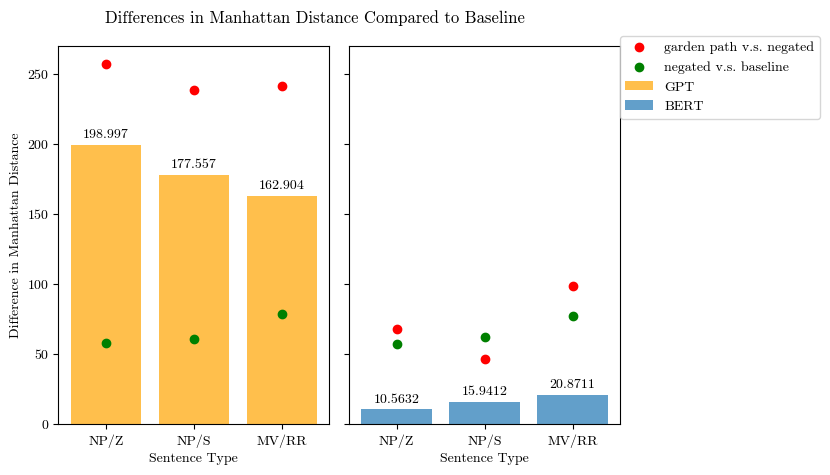

In [63]:
sentence_types = ['NP/Z', 'NP/S', 'MV/RR']

dist_means_diff_gpt = np.abs(means_gpt['diff_dist'])
dist_means_diff_bert = np.abs(means_bert['diff_dist'])

fig, ax = plt.subplots(1, 2, sharey=True)
rect1 = ax[0].bar(sentence_types, dist_means_diff_gpt, alpha=0.7, label='GPT', color='orange')
rect2 = ax[1].bar(sentence_types, dist_means_diff_bert, alpha=0.7, label='BERT')
ax[0].bar_label(rect1, padding=3)
ax[1].bar_label(rect2, padding=3)
ax[0].scatter(sentence_types, means_gpt['orig_dist'], label='garden path v.s. negated', color='red')
ax[0].scatter(sentence_types, means_gpt['repl_dist'], label='negated v.s. baseline', color='green')
ax[1].scatter(sentence_types, means_bert['orig_dist'], color='red')
ax[1].scatter(sentence_types, means_bert['repl_dist'], color='green')
ax[0].set_xlabel('Sentence Type')
ax[1].set_xlabel('Sentence Type')
ax[0].set_ylabel('Difference in Manhattan Distance')
fig.suptitle('Differences in Manhattan Distance Compared to Baseline')
#ax[1].set_title('Differences in Manhattan Distance Compared to Baseline')
fig.legend(loc=1, bbox_to_anchor=(1.3, 0.94))
fig.tight_layout()


/tmp/ipykernel_364346/3376991120.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 2, sharey=True)


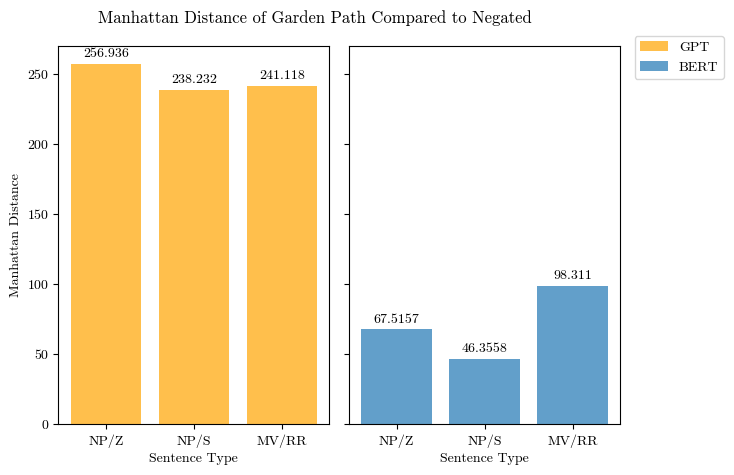

In [64]:
dist_means_diff_gpt = np.abs(means_gpt['diff_dist'])
dist_means_diff_bert = np.abs(means_bert['diff_dist'])

fig, ax = plt.subplots(1, 2, sharey=True)
#plt.scatter(sentence_types, dist_means_orig)
#plt.scatter(sentence_types, dist_means_rep)
rect1 = ax[0].bar(sentence_types, np.abs(means_gpt['orig_dist']), alpha=0.7, label='GPT', color='orange')
rect2 = ax[1].bar(sentence_types, np.abs(means_bert['orig_dist']), alpha=0.7, label='BERT')
ax[0].bar_label(rect1, padding=3)
ax[1].bar_label(rect2, padding=3)
ax[0].set_xlabel('Sentence Type')
ax[1].set_xlabel('Sentence Type')
ax[0].set_ylabel('Manhattan Distance')
fig.suptitle('Manhattan Distance of Garden Path Compared to Negated')
#ax[1].set_title('Differences in Manhattan Distance Compared to Baseline')
fig.legend(loc=1, bbox_to_anchor=(1.15, 0.94))
fig.tight_layout()


/tmp/ipykernel_364346/4069239204.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 2)


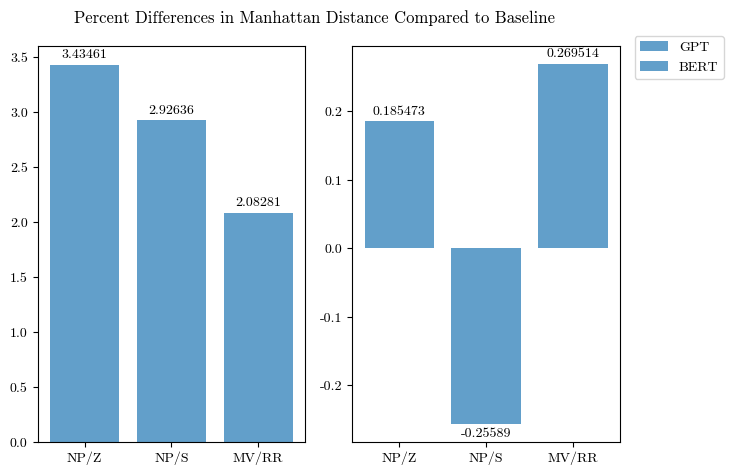

In [25]:
dist_means_diff_gpt = means_gpt['diff_dist']

dist_means_diff_bert = means_bert['diff_dist']

fig, ax = plt.subplots(1, 2)
#plt.scatter(sentence_types, dist_means_orig)
#plt.scatter(sentence_types, dist_means_rep)
rect1 = ax[0].bar(sentence_types, [dist_means_diff_gpt[i] / means_gpt['repl_dist'][i] for i in range(len(dist_means_diff_gpt))], alpha=0.7, label='GPT')
rect2 = ax[1].bar(sentence_types, [dist_means_diff_bert[i] / means_bert['repl_dist'][i] for i in range(len(dist_means_diff_bert))], alpha=0.7, label='BERT')
ax[0].bar_label(rect1, padding=3)
ax[1].bar_label(rect2, padding=3)
fig.suptitle('Percent Differences in Manhattan Distance Compared to Baseline')
fig.legend(loc=1, bbox_to_anchor=(1.15, 0.94))
fig.tight_layout()


/tmp/ipykernel_364346/657905770.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig2, ax2 = plt.subplots(1,2, sharey=True)


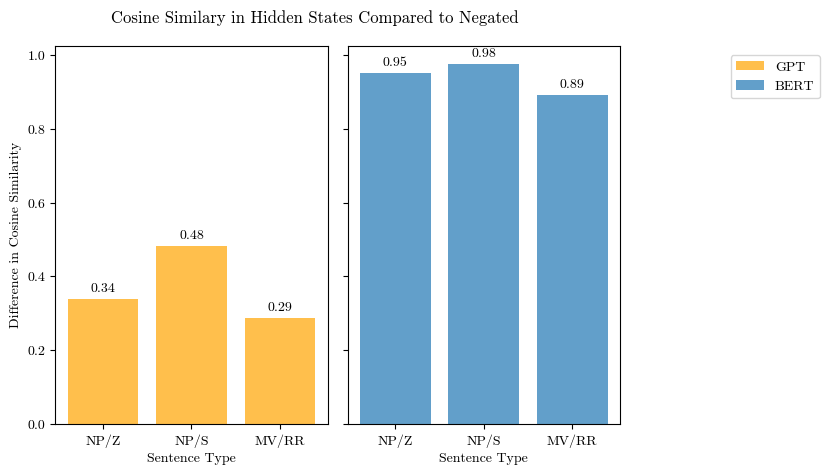

In [65]:
fig2, ax2 = plt.subplots(1,2, sharey=True)
bars1 = ax2[0].bar(sentence_types, means_gpt['orig_sim'], alpha=0.7, label='GPT', color='orange')
bars2 = ax2[1].bar(sentence_types, means_bert['orig_sim'], alpha=0.7, label='BERT')


# Add labels on top of the bars for the first subplot
for bar in bars1:
    height = bar.get_height()
    ax2[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# Add labels on top of the bars for the second subplot
for bar in bars2:
    height = bar.get_height()
    ax2[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                        textcoords="offset points", ha='center', va='bottom')
fig2.legend(loc=1, bbox_to_anchor=(1.3, 0.9))
ax2[0].set_xlabel('Sentence Type')
ax2[1].set_xlabel('Sentence Type')
ax2[0].set_ylabel('Difference in Cosine Similarity')
# Set labels and title
fig2.suptitle('Cosine Similary in Hidden States Compared to Negated')
fig2.tight_layout()

# scatter or bar 

/tmp/ipykernel_364346/3789757854.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig2, ax2 = plt.subplots(1,2, sharey=True)


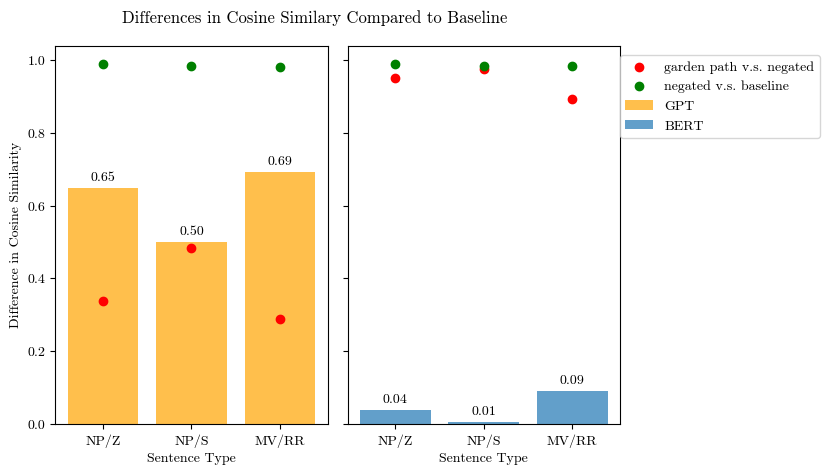

In [66]:
fig2, ax2 = plt.subplots(1,2, sharey=True)
bars1 = ax2[0].bar(sentence_types, np.abs(means_gpt['diff_sim']), alpha=0.7, label='GPT', color='orange')
bars2 = ax2[1].bar(sentence_types, np.abs(means_bert['diff_sim'])
                   , alpha=0.7, label='BERT')


# Add labels on top of the bars for the first subplot
for bar in bars1:
    height = bar.get_height()
    ax2[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# Add labels on top of the bars for the second subplot
for bar in bars2:
    height = bar.get_height()
    ax2[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                        textcoords="offset points", ha='center', va='bottom')
    
ax2[0].scatter(sentence_types, means_gpt['orig_sim'], label='garden path v.s. negated', color='red')
ax2[0].scatter(sentence_types, means_gpt['repl_sim'], label='negated v.s. baseline', color='green')
ax2[1].scatter(sentence_types, means_bert['orig_sim'], color='red')
ax2[1].scatter(sentence_types, means_bert['repl_sim'], color='green')
ax2[0].set_xlabel('Sentence Type')
ax2[1].set_xlabel('Sentence Type')
ax2[0].set_ylabel('Difference in Cosine Similarity')   
# Set labels and title
fig2.legend(loc=1, bbox_to_anchor=(1.3, 0.9))
fig2.suptitle('Differences in Cosine Similary Compared to Baseline')
fig2.tight_layout()

/tmp/ipykernel_364346/14019104.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig2, ax2 = plt.subplots(1,2,sharey=True)


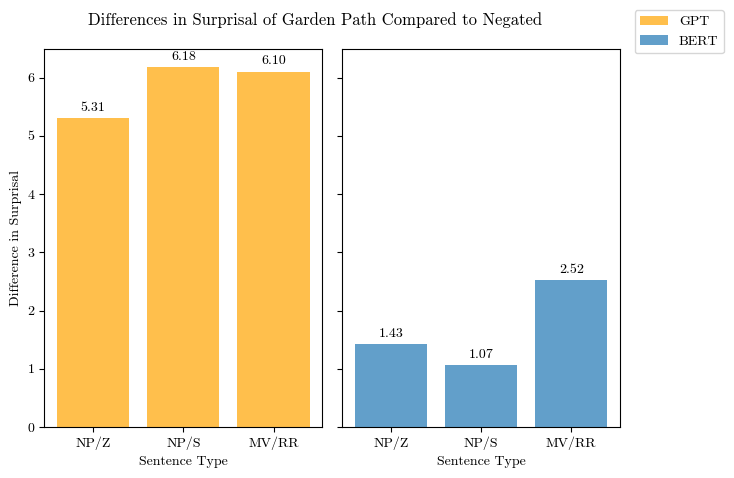

In [67]:
fig2, ax2 = plt.subplots(1,2,sharey=True)
rect1 = ax2[0].bar(sentence_types, means_gpt['surp'], alpha=0.7, label='GPT', color='orange')
rect2 = ax2[1].bar(sentence_types, means_bert['surp'], alpha=0.7, label='BERT')
# Add labels on top of the bars for the first subplot
for bar in rect1:
    height = bar.get_height()
    ax2[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# Add labels on top of the bars for the second subplot
for bar in rect2:
    height = bar.get_height()
    ax2[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                                                            textcoords="offset points", ha='center', va='bottom')
ax2[0].set_xlabel('Sentence Type')
ax2[1].set_xlabel('Sentence Type')
ax2[0].set_ylabel('Difference in Surprisal')   
fig2.legend(loc=1, bbox_to_anchor=(1.15, 1))
fig2.suptitle('Differences in Surprisal of Garden Path Compared to Negated')
fig2.tight_layout()

In [26]:
sentence_types = ['NPZ', 'NPS', 'VA']

dist_means_orig = means['orig_dist']
sim_means_orig = means['orig_sim']
surp_means_orig = means['surp']

dist_means_rep = means['repl_dist']
sim_means_rep = means['repl_sim']


# Graph 1: Manhattan Distance
plt.figure()
plt.bar(sentence_types, dist_means_orig, alpha=0.7)
plt.bar(sentence_types, dist_means_rep, alpha=0.7)
plt.xlabel('Sentence Types')
plt.ylabel('Mean')
plt.title('Manhattan Distance')
plt.show()

# Graph 2: Cosine Similarity
plt.figure()
plt.bar(sentence_types, sim_means_orig, alpha=0.7)
plt.bar(sentence_types, sim_means_rep, alpha=0.7)
plt.xlabel('Sentence Types')
plt.ylabel('Mean')
plt.title('Cosine Similarity')
plt.show()

# Graph 3: Surprisal
plt.figure()
plt.bar(sentence_types, surp_means_rep, alpha=0.7)
plt.bar(sentence_types, surp_means_orig, alpha=0.7)
plt.xlabel('Sentence Types')
plt.ylabel('Mean')
plt.title('Surprisal')
plt.show()

NameError: name 'means' is not defined

# misc

In [21]:
# get mean value from each sentence type under each metric 
replaced_results = {'npz':npz_replaced_results, 'nps': nps_replaced_results, 'va':va_replaced_results}
replaced_means = {'dist': [], 'sim': [], 'surp': []}
replaced_stds = {'dist': [], 'sim': [], 'surp': []}
for sent_type in replaced_results.keys():
    print(sent_type)
    result = replaced_results[sent_type]
    cutoffs = result['cutoffs']
    dists = result['dists']
    cuts = [cutoff - 1 for cutoff in cutoffs]
    cut_dists = [dists[i][cuts[i]] for i in range(len(dists))]
    replaced_means['dist'].append(np.mean(cut_dists))
    replaced_stds['dist'].append(np.std(cut_dists))
    print('gp:', np.mean(cut_dists), np.std(cut_dists))
    
    sims = result['sims']
    cut_sims = [sims[i][cuts[i]] for i in range(len(sims))]
    replaced_means['sim'].append(np.mean(cut_sims))
    replaced_stds['sim'].append(np.std(cut_sims))
    print('gp:', np.mean(cut_sims), np.std(cut_sims))
    
    surps = result['surps']
    cut_surps = [surps[i][cutoffs[i]] for i in range(len(surps))]
    replaced_means['surp'].append(np.mean(cut_surps))
    replaced_stds['surp'].append(np.std(cut_surps))
    print('gp:', np.mean(cut_surps), np.std(cut_surps))

npz
gp: 255.08054 67.92856
gp: 0.35123572 0.5028619
gp: 5.391789463096208 2.4808735280432246
nps
gp: 243.37259 65.543526
gp: 0.46480998 0.52829885
gp: 6.282846829783044 2.661894407891889
va
gp: 231.87206 75.11081
gp: 0.36273998 0.49705735
gp: 5.491368813947806 2.7428884239429085


/tmp/ipykernel_225956/1621411045.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.bar(sentence_types, dist_means_orig, alpha=0.7)


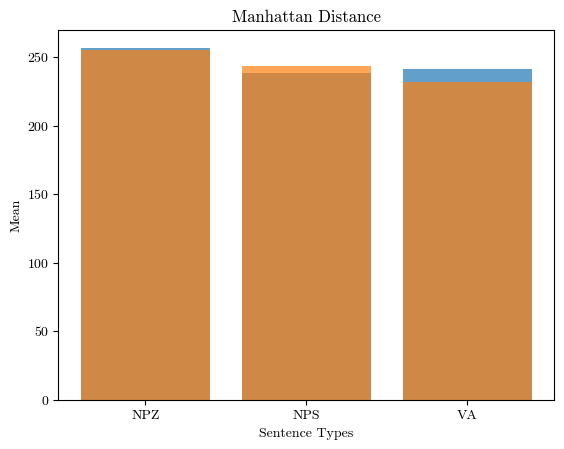

/tmp/ipykernel_225956/1621411045.py:23: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.bar(sentence_types, sim_means_orig, alpha=0.7)


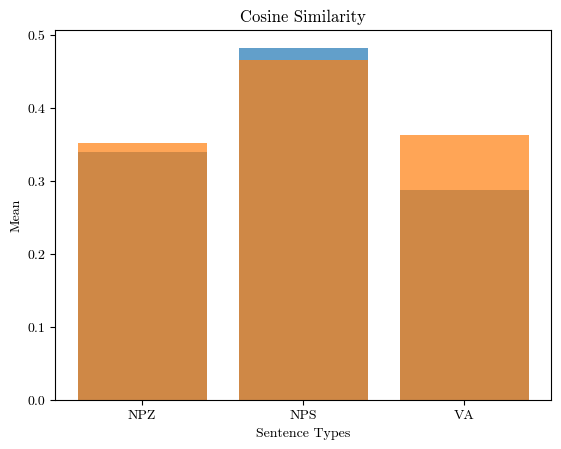

/tmp/ipykernel_225956/1621411045.py:32: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.bar(sentence_types, surp_means_orig, alpha=0.7)


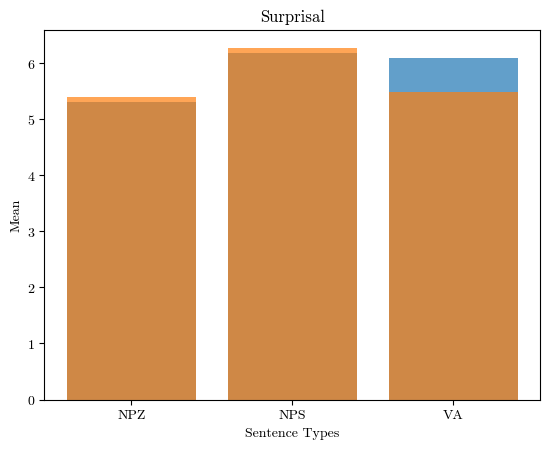

In [23]:
# Sentence types
sentence_types = ['NPZ', 'NPS', 'VA']

dist_means_orig = orig_means['dist']
sim_means_orig = orig_means['sim']
surp_means_orig = orig_means['surp']

dist_means_rep = replaced_means['dist']
sim_means_rep = replaced_means['sim']
surp_means_rep = replaced_means['surp']

# Graph 1: Manhattan Distance
plt.figure()
plt.bar(sentence_types, dist_means_orig, alpha=0.7)
plt.bar(sentence_types, dist_means_rep, alpha=0.7)
plt.xlabel('Sentence Types')
plt.ylabel('Mean')
plt.title('Manhattan Distance')
plt.show()

# Graph 2: Cosine Similarity
plt.figure()
plt.bar(sentence_types, sim_means_orig, alpha=0.7)
plt.bar(sentence_types, sim_means_rep, alpha=0.7)
plt.xlabel('Sentence Types')
plt.ylabel('Mean')
plt.title('Cosine Similarity')
plt.show()

# Graph 3: Surprisal
plt.figure()
plt.bar(sentence_types, surp_means_orig, alpha=0.7)
plt.bar(sentence_types, surp_means_rep, alpha=0.7)
plt.xlabel('Sentence Types')
plt.ylabel('Mean')
plt.title('Surprisal')
plt.show()

/tmp/ipykernel_138177/609684748.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()


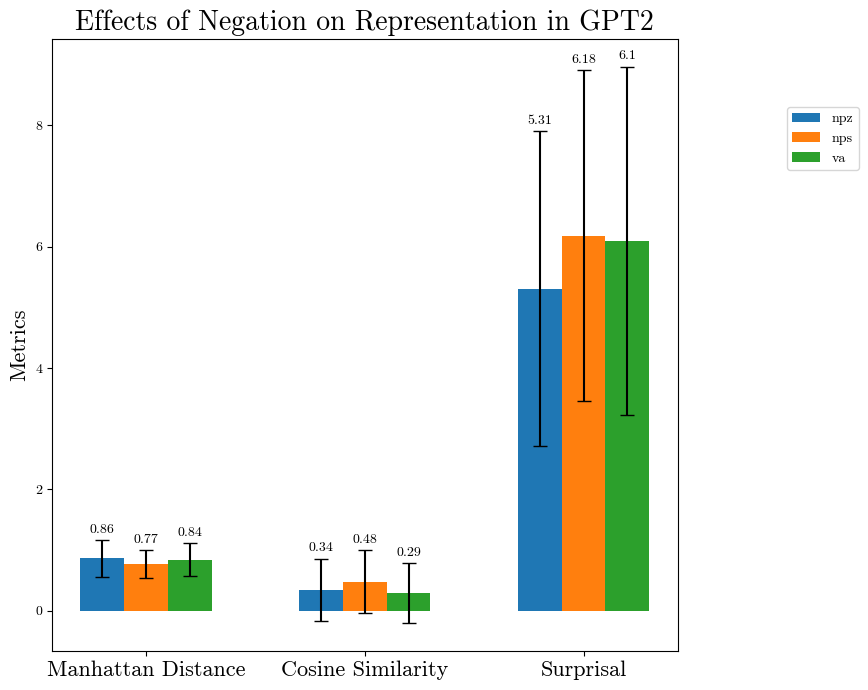

In [29]:
def round_list(l, n):
    return [round(i, n) for i in l]

font = {'fontname':'Times New Roman'}
width = 0.2
sigfigs = 2
npz_means = round_list([0.8551064, 0.3366954, 5.310581073175412], sigfigs)
npz_stds = [0.3038145, 0.5167533, 2.5913197312229355]
nps_means = round_list([0.76708156, 0.48257962, 6.184383299881774], sigfigs)
nps_stds = [0.22537614, 0.5215427, 2.7242632364775146]
va_means = round_list([0.8423193, 0.28757694, 6.103413270442145], sigfigs)
va_stds = [0.27407706, 0.4931776, 2.867380947109898]
types = ['Manhattan Distance', 'Cosine Similarity', 'Surprisal']
labels = ['npz', 'nps', 'va']
cmap = ['blue', 'orange', 'green']
0.8551064
x = np.arange(len(types))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, npz_means, width, yerr=npz_stds, capsize=5, label='npz')
rects2 = ax.bar(x, nps_means, width, yerr=nps_stds, capsize=5, label='nps')
rects3 = ax.bar(x + width, va_means, width, yerr=va_stds, capsize=5, label='va')

ax.set_ylabel('Metrics', fontsize=16)
ax.set_title('Effects of Negation on Representation in GPT2', fontsize=20)
ax.set_xticks(x, types, fontsize=16)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

ax.legend(# How to specify the location of the legend. Think of the first two bb_to_anchor args as x, y coordinates of the lagend. 
         bbox_to_anchor=(0.3, 1.1, 1, -0.2), loc='upper right',
                   fontsize=10)
    

fig.set_size_inches(9, 7)

fig.tight_layout()
plt.show()

/tmp/ipykernel_48101/991270220.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()


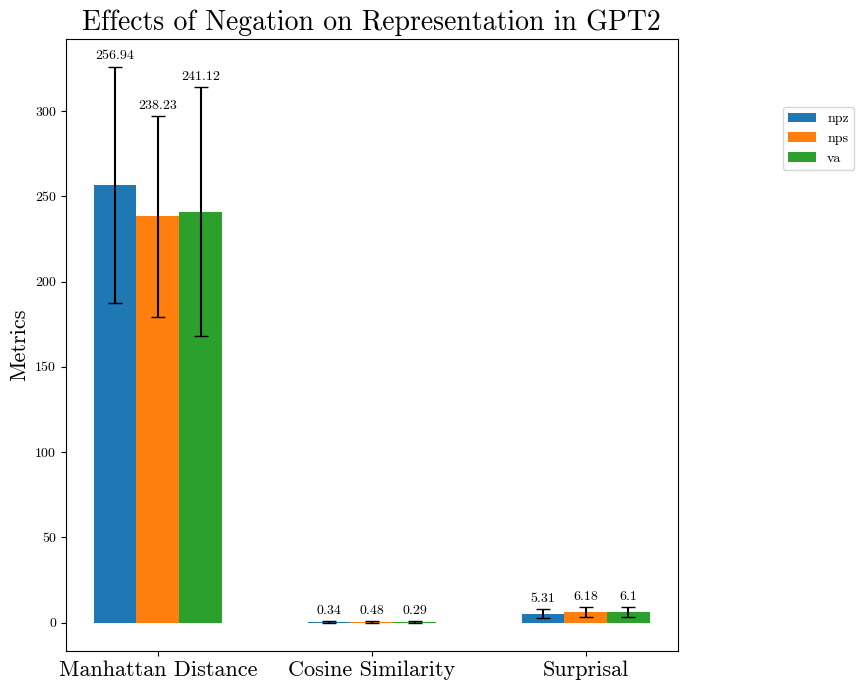

In [22]:
"""
def round_list(l, n):
    return [round(i, n) for i in l]

font = {'fontname':'Times New Roman'}
width = 0.2
sigfigs = 2
npz_means = round_list([256.93558, 0.3366954, 5.310581073175412], sigfigs)
npz_stds = [69.17926, 0.5167533, 2.5913197312229355]
nps_means = round_list([238.23183, 0.48257962, 6.184383299881774], sigfigs)
nps_stds = [58.85483, 0.5215427, 2.7242632364775146]
va_means = round_list([241.1177, 0.28757694, 6.103413270442145], sigfigs)
va_stds = [72.91913, 0.4931776, 2.867380947109898]
types = ['Manhattan Distance', 'Cosine Similarity', 'Surprisal']
labels = ['npz', 'nps', 'va']
cmap = ['blue', 'orange', 'green']

x = np.arange(len(types))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, npz_means, width, yerr=npz_stds, capsize=5, label='npz')
rects2 = ax.bar(x, nps_means, width, yerr=nps_stds, capsize=5, label='nps')
rects3 = ax.bar(x + width, va_means, width, yerr=va_stds, capsize=5, label='va')

ax.set_ylabel('Metrics', fontsize=16)
ax.set_title('Effects of Negation on Representation in GPT2', fontsize=20)
ax.set_xticks(x, types, fontsize=16)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

ax.legend(# How to specify the location of the legend. Think of the first two bb_to_anchor args as x, y coordinates of the lagend. 
         bbox_to_anchor=(0.3, 1.1, 1, -0.2), loc='upper right',
                   fontsize=10)
    

fig.set_size_inches(9, 7)

fig.tight_layout()
plt.show()
"""


# adapt to BERT

In [89]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
lmhmodel = BertForMaskedLM.from_pretrained("bert-base-uncased")

def embed_bert(tokenizer, model, sentence, output_hidden_states=True):
    """Given a model and a tokenizer, embed() will return embeddings for each token in the sentence. You can 
    return the attention matrices and the full hidden state dictionaries if desired."""

    model.eval()

    # Tokenize the sentence
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=1024
    )

    tokens_tensor = encoding['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.squeeze().tolist())

    with torch.no_grad():
        outputs = model(tokens_tensor, output_hidden_states=output_hidden_states)
        last_layer = outputs.last_hidden_state

    return np.squeeze(last_layer), tokens

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relations

In [93]:
def distance_track_bert(primed, unprimed, postfix, tokenizer, model, p=1):
    coords, tokens = embed_bert(tokenizer, model, primed)
    _coords, _tokens = embed_bert(tokenizer, model, unprimed) #underscore means its been tampered, doesn't have GP effect
    print(tokens)
    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    post_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(post_tokens_tensor))
    aft = len(post_tokens)
    __coords = []
    j = 0
    for i in range(len(_tokens)):
        if _tokens[i] == tokens[j]:
            j += 1
            __coords.append(_coords[i].cpu().detach().numpy())
            
    __coords = np.array(__coords)
    coords = coords.cpu().detach().numpy()
    # added np.abs, as well as the division over np.sum(coords)
    print('coords', coords)
    print('__coords', __coords)
    print('numerator', np.sum(np.abs(__coords - coords), axis=1))
    print('denominator', np.sum(coords, axis=1))
    #dists = np.abs(np.sum(np.abs(__coords - coords), axis=1) / np.sum(coords, axis=1))
    dists = np.abs(np.sum(__coords, axis=1) - np.sum(coords, axis=1)) / np.sum(coords, axis=1)
    diffs = __coords - coords
    
    mn = np.mean(np.concatenate((__coords, coords), axis=0), axis=0)
    __normed = np.subtract(__coords, mn)
    normed = np.subtract(coords, mn)
    sims = (__normed * normed).sum(axis=1)/(np.linalg.norm(__normed, axis=1)*np.linalg.norm(normed, axis=1))
    cutoff = len(dists) - aft
    return dists, sims, diffs, cutoff

def distance_tracks_bert(get_components, kwargs, tokenizer, model):
    pre, post = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _ = get_components(**kwargs)
    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    dists = []
    sims = []
    diffs = []
    cutoffs = []
    for i in range(n):
        dist, sim, diff, cutoff = distance_track_bert(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, model)
        dists.append(dist)
        sims.append(sim)
        diffs.append(diff)
        cutoffs.append(cutoff)

    return dists, sims, diffs, cutoffs

In [100]:
def surprisal_track_bert(primed, unprimed, postfix, tokenizer, lmhmodel):
    lmhmodel.eval()
    print(primed)
    print(unprimed)

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    aft = len(post_tokens_tensor[0])

    sent_tokens = tokenizer.tokenize(primed)
    indexed_tokens = tokenizer.convert_tokens_to_ids(sent_tokens)
    # create 1 * T input token tensor
    tokens_tensor = torch.tensor(indexed_tokens).unsqueeze(0)
    
    _sent_tokens = tokenizer.tokenize(unprimed)
    _indexed_tokens = tokenizer.convert_tokens_to_ids(_sent_tokens)
    # create 1 * T input token tensor
    _tokens_tensor = torch.tensor(_indexed_tokens).unsqueeze(0)
    with torch.no_grad():
        outputs = lmhmodel(tokens_tensor)
        _outputs = lmhmodel(_tokens_tensor)

    # outputs has key 'logits'
    logprobs = outputs[0].log_softmax(dim=2).squeeze()
    _logprobs = _outputs[0].log_softmax(dim=2).squeeze()
    predictions = list(zip(sent_tokens, indexed_tokens, (None,) + logprobs.unbind()))
    _predictions = list(zip(_sent_tokens, _indexed_tokens, (None,) + _logprobs.unbind()))
    
    surprisals = []
    for word, word_idx, preds in predictions:
        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        surprisals.append((word, word_idx, surprisal))

    _surprisals = []
    i = 0
    for word, word_idx, preds in _predictions:
        if word == predictions[i][0]:
            i += 1
        else:
            continue

        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        _surprisals.append((word, word_idx, surprisal))

    assert len(surprisals) == len(_surprisals)
    # TODO: changed subtraction
    #return [surprisals[i][-1] - _surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft
    return [_surprisals[i][-1] - surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft

def surprisal_tracks_bert(get_components, kwargs, tokenizer, lmhmodel):
    pre, post = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _ = get_components(**kwargs)

    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    surprisal_diffs = []
    cutoffs = []
    for i in range(n):
        diff, cutoff = surprisal_track_bert(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, lmhmodel)
        surprisal_diffs.append(diff)
        cutoffs.append(cutoff)
    
    return surprisal_diffs, cutoffs

In [101]:
npz_results_bert = {}
nps_results_bert = {}
va_results_bert = {}
gp_types = ['npz', 'nps', 'va']

for gp_type in gp_types:
    if gp_type == 'npz':
        print('---NPZ---')
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'comma':False}
        dists, sims, diffs, cutoffs = distance_tracks_bert(get_components_npz, kwargs, tokenizer, model)
        npz_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'comma':False}
        surps, cutoffs = surprisal_tracks_bert(get_components_npz, kwargs, tokenizer, lmhmodel)
        npz_results_bert['surps'] = surps
        npz_results_bert['surps_cutoffs'] = cutoffs

    elif gp_type == 'nps':
        print('---NPS---')
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'that':False}
        dists, sims, diffs, cutoffs = distance_tracks_bert(get_components_nps, kwargs, tokenizer, model)
        nps_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'that':False}
        surps, cutoffs = surprisal_tracks_bert(get_components_nps, kwargs, tokenizer, lmhmodel)
        nps_results_bert['surps'] = surps
        nps_results_bert['surps_cutoffs'] = cutoffs

    elif gp_type == 'va':
        print('---va---')
        kwargs = {'sent_type':'gp', 'intervener':True, 'unreduced':False}
        dists, sims, diffs, cutoffs = distance_tracks_bert(get_components_va, kwargs, tokenizer, model)
        va_results_bert = {
            'dists': dists,
            'sims': sims,
            'diffs': diffs,
            'cutoffs': cutoffs
        }
        kwargs = {'sent_type':'gp', 'intervener':True, 'unreduced':False}
        surps, cutoffs = surprisal_tracks_bert(get_components_va, kwargs, tokenizer, lmhmodel)
        va_results_bert['surps'] = surps
        va_results_bert['surps_cutoffs'] = cutoffs


---NPZ---
including columns: ['Start', 'Context', 'Transitive Verb', 'NP/Z', 'Extension', 'Verb', 'Rest']
including columns: ['Start', 'Context', 'Transitive Verb', 'Comma', 'NP/Z', 'Extension', 'Verb', 'Rest']
['[CLS]', 'as', 'the', 'gangster', 'who', 'killed', 'for', 'money', 'shot', 'the', 'woman', 'with', 'her', 'young', 'daughters', 'burst', 'into', 'h', '##yst', '##eric', '##s', '.', '[SEP]']
coords [[ 0.11267257 -0.0830051   0.18568228 ... -0.45583028  0.2359416
   0.23842134]
 [ 0.5068948   0.31763515  0.45236862 ... -0.17922266  0.13877779
  -0.19225149]
 [-0.38039237 -0.55640274  0.11444809 ... -0.24967036  0.35075256
  -0.34955776]
 ...
 [ 0.04241413 -0.19948211  0.68129253 ... -0.54330254  0.30853534
   0.18595612]
 [ 0.452763    0.28267953 -0.01750149 ... -0.0160018  -0.43850043
  -0.22443834]
 [ 0.39587155  0.08150762  0.46844307 ... -0.25766173 -0.4048318
  -0.6303842 ]]
__coords [[ 0.07280595 -0.00636834  0.20353341 ... -0.29722652  0.17409807
   0.46650827]
 [ 0.604977

['[CLS]', 'while', 'the', 'crowd', 'that', 'attended', 'the', 'show', 'app', '##lau', '##ded', 'the', 'performer', 'in', 'the', 'bizarre', 'outfit', 'rested', 'backstage', '.', '[SEP]']
coords [[-0.02199494 -0.17906632  0.17036216 ... -0.14472987  0.27891946
   0.25323528]
 [ 0.46145827  0.08569637 -0.21093066 ... -0.3480798   0.4378799
   0.13780576]
 [-0.07432181 -0.46030778 -0.02737729 ... -0.16354172  0.625916
  -0.2951629 ]
 ...
 [ 0.7110316  -0.64023256  0.12068483 ... -0.11080907  0.21645594
   0.3555992 ]
 [ 0.16739672  0.24329244  0.03296513 ...  0.41733408 -0.13925526
  -0.4688924 ]
 [ 0.07721084  0.507459    0.20090212 ...  0.6464879  -0.42019126
  -0.3153232 ]]
__coords [[ 7.7486120e-02 -2.0711558e-01  4.9723692e-02 ... -1.2787509e-01
   2.8596076e-01  3.0489114e-01]
 [ 1.8079495e-01  9.4233282e-02 -4.8373133e-01 ... -5.5236209e-02
   6.5437925e-01  2.8759265e-01]
 [ 8.6713126e-03 -5.4972965e-01 -8.2356535e-02 ... -2.0971960e-01
   7.4321580e-01 -2.2458175e-01]
 ...
 [ 7.35

['[CLS]', 'after', 'the', 'patient', 'with', 'a', 'sore', 'throat', 'asked', 'the', 'nurse', 'who', 'was', 'very', 'caring', 'told', 'her', 'the', 'news', '.', '[SEP]']
coords [[-0.05814109 -0.02251444 -0.15634039 ...  0.13616268  0.29424334
   0.5205472 ]
 [ 0.19711773  0.01705339 -0.16516858 ... -0.02644927  0.19088194
   0.3648704 ]
 [-0.6887148  -0.3753336   0.04032835 ... -0.02212566  0.48958498
   0.17564967]
 ...
 [-0.15865998 -0.2871304   0.04011928 ... -0.00419001 -0.09900609
  -0.04535762]
 [ 0.5607995   0.08650745 -0.03248277 ...  0.36894587 -0.42634767
  -0.51710755]
 [ 0.23059855  0.02542352  0.115637   ...  0.40303662 -0.40352842
  -0.5586384 ]]
__coords [[-0.04890442  0.0758905  -0.12173477 ...  0.28413558  0.16278593
   0.70020765]
 [ 0.06962569  0.3879738  -0.19021642 ...  0.23333815  0.04013188
   0.47439617]
 [-0.6502782  -0.29948604  0.07976916 ...  0.11095995  0.42974293
   0.2956497 ]
 ...
 [-0.17701453 -0.24619535  0.03268754 ...  0.08270221 -0.21031602
   0.0406

['[CLS]', 'as', 'the', 'bachelor', 'with', 'a', 'nico', '##tine', 'habit', 'smoked', 'the', 'pipe', 'containing', 'his', 'best', 'tobacco', 'fell', 'to', 'the', 'floor', '.', '[SEP]']
coords [[-0.29439998  0.4352628   0.02318045 ... -0.17359293  0.491713
   0.21227352]
 [ 0.40816197  0.6773935   0.34655416 ...  0.04948825  0.44665608
  -0.17171344]
 [-0.19084339 -0.00732286  0.11727696 ...  0.11763282  1.0485991
  -0.5743024 ]
 ...
 [ 0.64716494  0.32818684 -0.7885467  ... -0.3301379   0.6201954
  -0.41996425]
 [ 0.19194095  0.10710651  0.05081356 ...  0.25700572 -0.1359343
  -0.5642284 ]
 [-0.28139266  1.0823873   0.9065186  ... -0.01629587  0.35660872
  -0.6203567 ]]
__coords [[-0.18955609  0.4948476   0.02546898 ... -0.2559226   0.57763904
   0.28739244]
 [ 0.34594336  0.65323246  0.19392817 ...  0.02448311  0.6030602
  -0.29566628]
 [-0.39554563 -0.12397625  0.15146527 ...  0.1243946   0.8685539
  -0.4008164 ]
 ...
 [ 0.6860175   0.2003778  -0.736385   ... -0.29869428  0.67178506
 

['[CLS]', 'as', 'the', 'guard', 'who', 'carried', 'a', 'ta', '##ser', 'bluff', '##ed', 'the', 'thieves', 'who', 'were', 'wearing', 'masks', 'grabbed', 'the', 'money', '.', '[SEP]']
coords [[-0.03707629  0.06458746  0.4182343  ... -0.16786905  0.22390881
   0.29296762]
 [ 0.3536218   0.3139468   0.25238547 ... -0.24584875  0.23460424
   0.21791176]
 [-0.12903756 -0.43045002 -0.26590532 ...  0.07425557  0.73502034
  -0.36912268]
 ...
 [ 0.58732235 -0.63472015 -0.39547077 ... -0.05027698  0.04655412
   0.03993903]
 [ 0.3654964  -0.11774075  0.24297637 ...  0.02233316 -0.35674465
  -0.15546843]
 [-0.00568082  0.11592513  0.5848007  ... -0.01895818 -0.06813755
  -0.5818342 ]]
__coords [[ 8.1266619e-02  8.4588312e-02  2.9899958e-01 ... -1.1497434e-01
   8.6847581e-02  4.7696394e-01]
 [ 5.1882833e-01  2.1611778e-01  1.9630207e-02 ... -1.8888901e-04
   1.3433844e-01  3.8621745e-01]
 [-1.0805638e-01 -3.7203738e-01 -2.8349590e-01 ...  1.6257966e-01
   5.6132847e-01 -8.0083348e-02]
 ...
 [ 6.6872

['[CLS]', 'because', 'the', 'class', 'that', 'memo', '##rized', 'the', 'constitution', 'failed', 'the', 'exam', 'that', 'was', 'worth', 'half', 'their', 'grade', 'was', 're', '##written', 'by', 'the', 'teacher', 'so', 'it', 'was', 'much', 'easier', '.', '[SEP]']
coords [[-0.03424165 -0.21397302 -0.22896099 ... -0.16069007  0.26347303
   0.823078  ]
 [ 0.5304108  -0.21625315  0.47961736 ...  0.0462769   0.5880818
   0.5294412 ]
 [-0.8969579  -0.43569311  0.02328169 ... -0.16930594  0.5855181
   0.3403761 ]
 ...
 [ 0.04582402  0.0077808   0.01968618 ... -0.01779444  0.4177874
  -0.37692812]
 [ 0.73186696  0.08413409 -0.28069115 ...  0.18359008 -0.5574561
  -0.06528298]
 [ 0.55342066  0.20980327  0.13988021 ...  0.38696906 -0.8356319
  -0.10404432]]
__coords [[-0.14401522 -0.20994008 -0.288248   ... -0.17779385  0.28311142
   0.6966421 ]
 [ 0.07235646 -0.17720732  0.21840711 ... -0.03170649  0.5254008
   0.67161393]
 [-0.810512   -0.41635457 -0.32523885 ... -0.22125697  0.5907767
   0.250

['[CLS]', 'even', 'though', 'the', 'girl', 'who', 'forgot', 'her', 'watch', 'phone', '##d', 'the', 'instructor', 'who', 'was', 'famously', 'strict', 'was', 'very', 'upset', 'with', 'her', 'for', 'missing', 'a', 'lesson', '.', '[SEP]']
coords [[-0.07026001 -0.38174438 -0.04865815 ... -0.21828412  0.2683301
   0.4850295 ]
 [-0.5139457  -0.41822174  0.19368894 ... -0.12069003  0.71044445
   0.5561767 ]
 [-0.5128361   0.43272695  0.7582106  ... -0.09180163 -0.13969083
   0.25487065]
 ...
 [ 0.48302945 -0.97405165 -0.23808092 ... -0.03628642 -0.4358097
  -0.9928191 ]
 [ 0.5509331   0.25488916 -0.14282165 ...  0.1358589  -0.4593099
  -0.373306  ]
 [ 0.5095873   0.35907573  0.11581247 ...  0.08878186 -0.5331241
  -0.3689478 ]]
__coords [[-0.05106954 -0.28316426 -0.25083902 ... -0.14931835  0.1871459
   0.57175267]
 [-0.3886147  -0.26451197 -0.16067839 ...  0.05912279  0.89286155
   0.65379506]
 [-0.3050156   0.42705747  0.50085765 ...  0.0430516  -0.05640068
   0.6405364 ]
 ...
 [ 0.5840503  

['[CLS]', 'in', 'case', 'the', 'team', 'which', 'fired', 'their', 'coach', 'lost', 'the', 'tie', '-', 'breaker', 'for', 'the', 'conference', 'title', 'was', 'scheduled', 'for', 'the', 'following', 'week', 'at', 'the', 'local', 'park', '.', '[SEP]']
coords [[-0.7352387  -0.5390578   0.14955847 ... -0.38463277  0.3218569
   0.51447743]
 [-1.0596488  -0.1862322  -0.06572736 ... -0.5425014   0.81410336
  -0.12010741]
 [-0.7804149  -0.12848346  1.2331072  ... -0.46990144  0.12206553
  -0.5208847 ]
 ...
 [ 0.34467715 -0.02366705  0.3823243  ... -0.17873965  0.2760101
   0.6233694 ]
 [ 0.5999565  -0.03257661 -0.5627477  ... -0.06809242 -0.3740204
  -0.21678765]
 [ 0.49309614  0.2913547  -0.29341438 ... -0.03131065 -0.60327965
  -0.11678533]]
__coords [[-0.8320231  -0.47724771  0.01801931 ... -0.25899807  0.38210183
   0.5994207 ]
 [-1.075383   -0.10649239 -0.28961158 ... -0.4354716   0.42188647
  -0.04208063]
 [-0.80329204  0.10682355  0.734448   ... -0.54541665  0.05255356
  -0.47179836]
 ..

['[CLS]', 'before', 'the', 'tribe', 'which', 'pierced', 'their', 'lips', 'worshipped', 'the', 'idol', 'that', 'resembled', 'their', 'god', 'was', 'placed', 'on', 'a', 'large', 'platform', '.', '[SEP]']
coords [[-0.4688271   0.22866772 -0.02112108 ... -0.3979674   0.41814816
   0.02002721]
 [ 0.12142229  0.62373763 -0.12284049 ... -0.5232889   0.2216521
  -0.01944155]
 [ 0.0328976   0.20042127 -0.23470597 ... -0.67998224  0.45969915
  -0.36843067]
 ...
 [ 0.64321196  0.6160908  -0.41528136 ... -0.31583625  0.591487
  -0.28345865]
 [ 0.43769142 -0.176336    0.1190638  ...  0.04552619 -0.34530476
  -0.45494935]
 [ 0.12511927  0.11802959  0.3476898  ...  0.06744966 -0.00716407
  -0.10443503]]
__coords [[-0.4810196   0.34771553  0.08754802 ... -0.46923217  0.5251168
  -0.14339271]
 [-0.19390824  0.5714612   0.11350258 ... -0.53733754  0.2104099
  -0.29333857]
 [-0.07999849  0.20685747 -0.12895203 ... -0.85339636  0.60712934
  -0.6140898 ]
 ...
 [ 0.58164555  0.72670287 -0.40237492 ... -0.38

When the dog with the black spot on his eye scratched the vet who was attending to him took off the muzzle.
When the dog with the black spot on his eye scratched, the vet who was attending to him took off the muzzle.
As the ship loaded with spices sailed the waters of the Atlantic Ocean remained blue and calm.
As the ship loaded with spices sailed, the waters of the Atlantic Ocean remained blue and calm.
After the pilgrims who sailed to America begged the Indians who sat by the fire lit a peace pipe.
After the pilgrims who sailed to America begged, the Indians who sat by the fire lit a peace pipe.
Though the swimmer who won several awards phoned the coach of the team refused to congratulate him.
Though the swimmer who won several awards phoned, the coach of the team refused to congratulate him.
While the crowd that attended the show applauded the performer in the bizarre outfit rested backstage.
While the crowd that attended the show applauded, the performer in the bizarre outfit reste

While the narrator who caught a cold read the story that had touched so many lives was dramatized by the troupe of skilled actors.
While the narrator who caught a cold read, the story that had touched so many lives was dramatized by the troupe of skilled actors.
Before the tribe which pierced their lips worshipped the idol that resembled their god was placed on a large platform.
Before the tribe which pierced their lips worshipped, the idol that resembled their god was placed on a large platform.
In case the manager who won several awards quit the company that he worked for began training new staff in several departments.
In case the manager who won several awards quit, the company that he worked for began training new staff in several departments.
As the customer who hated the meal paid the waitress who had served him could see how large the tip was.
As the customer who hated the meal paid, the waitress who had served him could see how large the tip was.
While the artist who decorated

['[CLS]', 'the', 'traveler', 'who', 'stayed', 'at', 'the', 'hotel', 'heard', 'the', 'clock', 'that', 'hung', 'above', 'the', 'desk', 'in', 'the', 'lobby', 'had', 'woken', 'everybody', 'up', 'in', 'the', 'youth', 'hospital', '.', '[SEP]']
coords [[ 0.16461572  0.06809316  0.39091006 ...  0.05691057  0.30381173
   0.27827108]
 [ 0.31887433 -0.5248667   0.1640213  ...  0.01944102  1.0768679
  -0.17460229]
 [ 0.53159463 -0.6343632   0.7287387  ... -0.27373242  0.35380152
  -0.43098268]
 ...
 [ 0.34809762  0.11270132  0.23604912 ...  0.2689288   0.33967146
   0.4814115 ]
 [ 0.6470874  -0.01721491 -0.08607218 ...  0.03318905 -0.51243544
  -0.37311685]
 [ 0.5034509   0.15072118  0.15199523 ...  0.08413179 -0.64851713
  -0.41570738]]
__coords [[ 0.18422961  0.16048884  0.08629688 ...  0.04798745  0.3556019
   0.36416838]
 [ 0.24416275 -0.49968967  0.1215713  ... -0.03808465  1.181737
  -0.25255483]
 [ 0.4884645  -0.6518159   0.76246524 ... -0.2820944   0.3952583
  -0.50514394]
 ...
 [ 0.261010

['[CLS]', 'the', 'committee', 'which', 'selected', 'the', 'location', 'mentioned', 'the', 'issue', 'that', 'they', 'planned', 'to', 'bring', 'up', 'would', 'cause', 'a', 'problem', 'at', 'the', 'meeting', '.', '[SEP]']
coords [[-0.3597804  -0.24376944 -0.10932551 ... -0.20877376  0.22522746
   0.57033545]
 [ 0.01336513 -0.6504365  -0.36169797 ... -0.20254879  0.6266271
   0.32339993]
 [ 0.5175847  -0.4581869  -0.23290834 ... -0.4667916   0.23955432
   0.74778503]
 ...
 [-0.284776   -0.8248969  -0.04326149 ... -0.2894022  -0.40124875
   0.18416713]
 [ 0.15277691  0.05614986 -0.07033912 ...  0.3474829  -0.30160502
  -0.11476279]
 [-0.7081426  -0.16184762  0.09458818 ... -0.11380269 -0.3851271
   0.09592792]]
__coords [[-0.40045723 -0.23918702 -0.20491214 ... -0.18677728  0.20983545
   0.64446396]
 [ 0.06846876 -0.5580566  -0.40266716 ... -0.23772304  0.6574795
   0.34380648]
 [ 0.51129174 -0.44148958 -0.29742002 ... -0.4245778   0.28617603
   0.71332216]
 ...
 [-0.30637062 -0.7948084  -0

['[CLS]', 'the', 'woman', 'who', 'proof', '##rea', '##d', 'the', 'ads', 'noticed', 'the', 'flyer', 'that', 'she', 'had', 'been', 'distributing', 'had', 'the', 'wrong', 'address', 'listed', 'on', 'the', 'front', '.', '[SEP]']
coords [[-0.26781392 -0.1578306  -0.17436165 ...  0.16814063  0.18553613
   0.50089407]
 [ 0.14353204 -0.7851438  -0.21081524 ... -0.11186291  0.66831857
  -0.35203186]
 [ 0.65725964 -0.5901316   0.17979498 ... -0.37517223  0.08872139
   0.3957512 ]
 ...
 [-0.65278417 -0.44325227  0.33613962 ...  0.1073541  -0.07863455
  -0.42511487]
 [ 0.4787031   0.10561188 -0.4447428  ...  0.3004439  -0.48074603
  -0.41133547]
 [ 0.3822141   0.35677296 -0.15737036 ...  0.31085148 -0.6492987
  -0.4289653 ]]
__coords [[-0.27716306 -0.09163931 -0.2356033  ...  0.18853125  0.25307092
   0.5268871 ]
 [ 0.15242352 -0.80109733 -0.26731265 ... -0.05887448  0.8250621
  -0.36916977]
 [ 0.6621349  -0.65994775  0.16699576 ... -0.33993232  0.10610588
   0.3452168 ]
 ...
 [-0.6758967  -0.3553

['[CLS]', 'the', 'reporter', 'who', 'worked', 'for', 'the', 'globe', 'revealed', 'the', 'politician', 'whose', 'financial', '##s', 'she', 'had', 'been', 'tracking', 'received', 'some', 'payments', 'from', 'the', 'un', '##sc', '##rup', '##ulous', 'millionaire', '.', '[SEP]']
coords [[-0.38927105 -0.15342684 -0.05327293 ... -0.14904295  0.37468642
   0.58205205]
 [-0.2224757  -1.0470723  -0.07149799 ... -0.00338913  0.8102008
  -0.3454364 ]
 [ 0.37376976 -0.59266305  0.2924614  ... -0.4471446   0.332079
  -0.37779358]
 ...
 [ 0.02725746 -0.6669014   0.5711324  ... -0.11665203  0.5710168
  -0.02161885]
 [ 0.2236853   0.21667126 -0.2779099  ... -0.04438159 -0.31282577
  -0.2352101 ]
 [-0.02898089  0.38246    -0.0411621  ...  0.16760838 -0.36965707
  -0.17182674]]
__coords [[-0.48944414 -0.08917908 -0.15901434 ... -0.11678737  0.39602408
   0.61306715]
 [-0.27664655 -1.0400311  -0.22542083 ... -0.00642903  0.6495952
  -0.39136827]
 [ 0.36122426 -0.6122931   0.17550328 ... -0.38454404  0.235

The mechanic who repaired dented vehicles accepted the car that was parked in his garage looked in worse shape than before he worked on it.
The mechanic who repaired dented vehicles accepted that the car that was parked in his garage looked in worse shape than before he worked on it.
The old man who fractured his skull recalled the nurse who was assigned to him had complained to the doctor that the patient never took his medication.
The old man who fractured his skull recalled that the nurse who was assigned to him had complained to the doctor that the patient never took his medication.
The traveler who stayed at the hotel heard the clock that hung above the desk in the lobby had woken everybody up in the youth hospital.
The traveler who stayed at the hotel heard that the clock that hung above the desk in the lobby had woken everybody up in the youth hospital.
The journalist who read the bulletin confirmed the story she wrote about the judge would be published on the front page the nex

['[CLS]', 'the', 'prisoners', 'pounded', 'for', 'hours', 'and', 'hours', 'in', 'the', 'morning', 'confessed', 'to', 'crimes', 'they', 'never', 'committed', '.', '[SEP]']
coords [[ 0.2564383   0.21771342 -0.27417168 ... -0.29538938  0.47925296
  -0.10169986]
 [ 0.66709113  0.1382793  -0.44505146 ...  0.03632025  1.0062252
  -0.7138345 ]
 [ 0.17615382  0.1377309  -0.12253572 ... -0.17439522  0.23390664
  -0.6200714 ]
 ...
 [ 0.6140119  -0.5113269  -0.3369485  ... -0.28049442  0.0898696
  -0.6301441 ]
 [ 0.49524796 -0.05484373 -0.3003568  ...  0.06624518 -0.38807163
  -0.5609867 ]
 [ 0.49846953  0.04707279 -0.04122183 ...  0.07511809 -0.5089601
  -0.57622534]]
__coords [[-0.00453754 -0.1663956  -0.5241186  ... -0.22860432  0.37251753
   0.22839528]
 [ 0.38601252 -0.05945485 -0.62181497 ...  0.05149116  0.67500263
  -0.64126134]
 [ 0.1492371   0.09630545 -0.32769597 ... -0.08867782  0.12581587
  -0.21820411]
 ...
 [ 0.7038029  -0.5310037  -0.398939   ... -0.24611437  0.11865919
  -0.532191

['[CLS]', 'the', 'artist', 'sketch', '##ed', 'a', 'hasty', 'portrait', 'of', 'the', 'woman', 'was', 'impressed', 'with', 'the', 'work', '.', '[SEP]']
coords [[-0.13148424 -0.04777566 -0.00772014 ... -0.06225009  0.1575708
   0.63110954]
 [ 0.44555643  0.02898066 -0.10279968 ... -0.19023661  1.0932876
  -0.26097938]
 [ 0.42699578  0.5879588   0.09900816 ... -0.23621063  0.38001162
  -0.37847885]
 ...
 [ 0.44237396  0.34981012  0.6643443  ... -0.21347569  0.00889039
   0.42611   ]
 [ 0.48581508  0.25135523 -0.27475324 ...  0.43745297 -0.7556385
  -0.38420126]
 [ 0.30774567  0.46586075  0.20021343 ...  0.5242188  -0.85737234
  -0.3949327 ]]
__coords [[-0.09161056 -0.14120087 -0.09029168 ...  0.01688753  0.11206181
   0.75317675]
 [ 0.33326036 -0.19581905 -0.2622847  ... -0.09765421  0.7325583
  -0.1777274 ]
 [ 0.6254608   0.4384054   0.10366856 ...  0.10540973  0.04137439
  -0.11685754]
 ...
 [ 0.5290096   0.24446101  0.5882898  ... -0.26909217 -0.00970309
   0.6095652 ]
 [ 0.66330135  0.

['[CLS]', 'the', 'player', 'tossed', 'the', 'plastic', 'fr', '##is', '##bee', 'during', 'the', 'game', 'dropped', 'it', 'on', 'the', 'ground', '.', '[SEP]']
coords [[-0.28147995 -0.26026833  0.05136183 ... -0.29373574  0.181811
   0.7739965 ]
 [-0.7387145  -0.3766345  -0.54158354 ... -0.01072672  0.5475712
   0.49393818]
 [-0.7648812  -0.6968733  -0.11799044 ... -0.65551645  0.47478673
   0.5559548 ]
 ...
 [ 0.34064603  0.04325217 -0.03411115 ... -0.2248525  -0.00120902
   0.12408704]
 [ 0.43310043 -0.1778468  -0.6422563  ...  0.2737537  -0.3990345
  -0.11219768]
 [-0.328187   -0.24904081  0.42019084 ... -0.00969157 -0.29339325
   0.10086449]]
__coords [[-0.50471973 -0.4555981  -0.10200503 ... -0.26469785  0.3763709
   0.9053749 ]
 [-1.128406   -0.6256262  -0.71011406 ...  0.0979683   0.47876668
   0.6423545 ]
 [-1.1089835  -0.8515897  -0.2615896  ... -0.50530505  0.42239243
   0.983694  ]
 ...
 [ 0.24552634  0.01150439  0.0298486  ... -0.24173115  0.11426452
   0.01561015]
 [ 0.528574

['[CLS]', 'the', 'dog', 'promenade', '##d', 'on', 'the', 'boardwalk', 'of', 'the', 'marina', 'barked', 'at', 'the', 'on', '##lo', '##oke', '##rs', '.', '[SEP]']
coords [[ 0.32079372  0.02962934  0.07840677 ... -0.2634468   0.30412695
   0.5384598 ]
 [ 0.34805024 -0.02997077 -0.6960422  ... -0.03817204  0.89307433
  -0.4335601 ]
 [ 0.7737382   0.08436979 -0.04410015 ... -0.94274014  0.3110977
   0.6542824 ]
 ...
 [ 0.61546373 -0.06428223  0.8535114  ... -0.5619197   0.35256124
  -0.0272243 ]
 [ 0.7378617   0.17294072 -0.42292488 ...  0.3692286  -0.34184396
  -0.39061683]
 [ 0.60011846  0.35518688 -0.02515354 ...  0.35419136 -0.4676071
  -0.34848812]]
__coords [[ 3.73636961e-01  1.42805204e-01 -3.76020633e-02 ... -2.13613182e-01
   3.90216529e-01  5.50328493e-01]
 [ 1.74021512e-01 -3.24813247e-01 -9.92073834e-01 ... -1.05734296e-01
   8.28106999e-01 -7.54714012e-02]
 [ 7.01955795e-01  2.91314274e-01  9.61305166e-04 ... -8.10538650e-01
   1.27137706e-01  6.78501308e-01]
 ...
 [ 6.13870859

['[CLS]', 'the', 'airplane', 'landed', 'in', 'the', 'arctic', 'in', 'the', 'winter', 'froze', 'during', 'the', 'ice', 'storm', '.', '[SEP]']
coords [[-0.24312334  0.00821057 -0.03411309 ... -0.646036    0.42870697
   0.43780273]
 [-0.38827398 -0.24710532 -0.50204635 ... -0.7449076   0.95643044
  -0.06839819]
 [ 0.39639518 -0.49575037 -0.19932233 ... -1.181718    0.8346072
  -0.0261287 ]
 ...
 [-0.11905976  0.2577672   0.41875625 ... -0.48331183 -0.44400474
  -0.41324276]
 [ 0.19869539  0.25525084 -0.38944125 ... -0.39690965 -0.38395542
  -0.5775057 ]
 [-0.16636068  0.41731697  0.18425575 ... -0.02179291 -0.5016504
  -0.8029174 ]]
__coords [[-0.04659426  0.07054297 -0.12287478 ... -0.524114    0.37213203
   0.58527154]
 [-0.25220177 -0.30501628 -0.50877285 ... -0.39273652  0.8815109
   0.4312663 ]
 [ 0.6956965  -0.6362754  -0.20042938 ... -0.8706297   0.45298663
   0.3824983 ]
 ...
 [-0.23561077  0.08415126  0.36363378 ... -0.49775016 -0.4534314
  -0.24190803]
 [ 0.01700344  0.12152087 

The girl stitched a new shawl out of wool lost it during the trip.
The girl who was stitched a new shawl out of wool lost it during the trip.
The airplane landed in the arctic in the winter froze during the ice storm.
The airplane that was landed in the arctic in the winter froze during the ice storm.
The toddler hurried down the hallway of the school sobbed at the top of his lungs.
The toddler that was hurried down the hallway of the school sobbed at the top of his lungs.


In [102]:
npz_results_bert = pd.DataFrame(npz_results_bert)
nps_results_bert = pd.DataFrame(nps_results_bert)
va_results_bert = pd.DataFrame(va_results_bert)
npz_results_bert.to_excel('npz_results_bert.xlsx', index=False)
nps_results_bert.to_excel('nps_results_bert.xlsx', index=False)
va_results_bert.to_excel('va_results_bert.xlsx', index=False)

In [103]:
# get mean value from each sentence type under each metric 
results_bert = {'npz':npz_results_bert, 'nps': nps_results_bert, 'va':va_results_bert}
for sent_type in results_bert.keys():
    print(sent_type)
    result = results_bert[sent_type]
    cutoffs = result['cutoffs']
    dists = result['dists']
    cuts = [cutoff - 1 for cutoff in cutoffs]
    cut_dists = [dists[i][cuts[i]] for i in range(len(dists))]
    print('gp:', np.mean(cut_dists), np.std(cut_dists))
    
    sims = result['sims']
    cut_sims = [sims[i][cuts[i]] for i in range(len(sims))]
    print('gp:', np.mean(cut_sims), np.std(cut_sims))
    
    surps = result['surps']
    cut_surps = [surps[i][cutoffs[i]] for i in range(len(surps))]
    print('gp:', np.mean(cut_surps), np.std(cut_surps))

npz
gp: -0.032388177 0.024665847
gp: 0.95045185 0.029823769
gp: 1.4320245972939893 3.2228804224362784
nps
gp: -0.024938738 0.018795053
gp: 0.9760152 0.017130245
gp: 1.0666096799782265 1.6926735818026295
va
gp: -0.046606414 0.036866724
gp: 0.8917319 0.07726601
gp: 2.5190417048525666 3.243318954775881


/tmp/ipykernel_138177/2200716355.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()


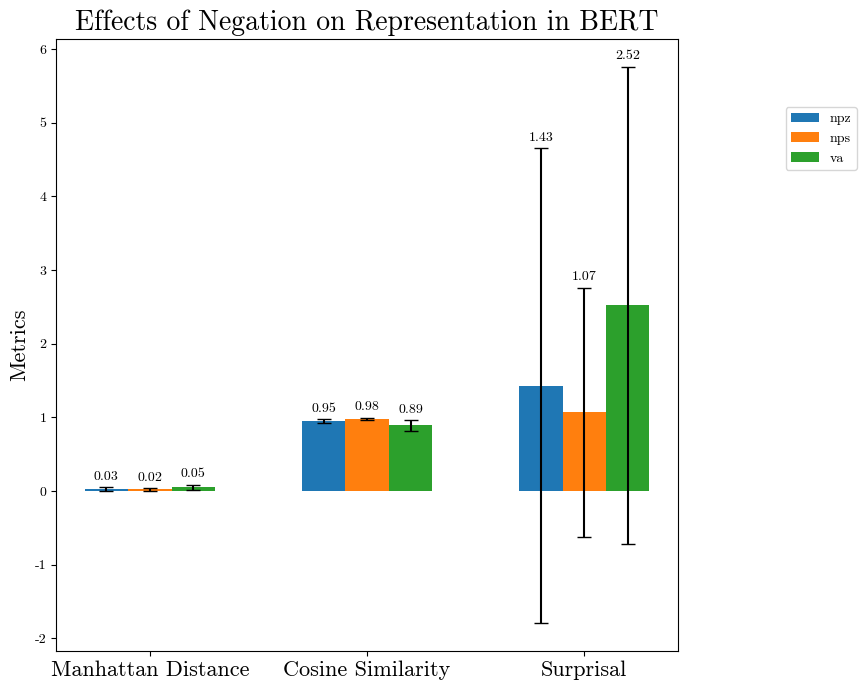

In [106]:
def round_list(l, n):
    return [round(i, n) for i in l]

font = {'fontname':'Times New Roman'}
width = 0.2
sigfigs = 2
npz_means = round_list([0.032388177, 0.950045185, 1.4320245972939893], sigfigs)
npz_stds = [0.024665847, 0.029823769, 3.2228804224362784]
nps_means = round_list([0.024938738, 0.9760152, 1.0666096799782265], sigfigs)
nps_stds = [0.018795053, 0.017130245, 1.6926735818026295]
va_means = round_list([0.046606414, 0.8917319, 2.5190417048525666], sigfigs)
va_stds = [0.036866724, 0.07726601, 3.243318954775881]
types = ['Manhattan Distance', 'Cosine Similarity', 'Surprisal']
labels = ['npz', 'nps', 'va']
cmap = ['blue', 'orange', 'green']

x = np.arange(len(types))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, npz_means, width, yerr=npz_stds, capsize=5, label='npz')
rects2 = ax.bar(x, nps_means, width, yerr=nps_stds, capsize=5, label='nps')
rects3 = ax.bar(x + width, va_means, width, yerr=va_stds, capsize=5, label='va')

ax.set_ylabel('Metrics', fontsize=16)
ax.set_title('Effects of Negation on Representation in BERT', fontsize=20)
ax.set_xticks(x, types, fontsize=16)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

ax.legend(# How to specify the location of the legend. Think of the first two bb_to_anchor args as x, y coordinates of the lagend. 
         bbox_to_anchor=(0.3, 1.1, 1, -0.2), loc='upper right',
                   fontsize=10)
    

fig.set_size_inches(9, 7)

fig.tight_layout()
plt.show()

/tmp/ipykernel_138177/3025441295.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()


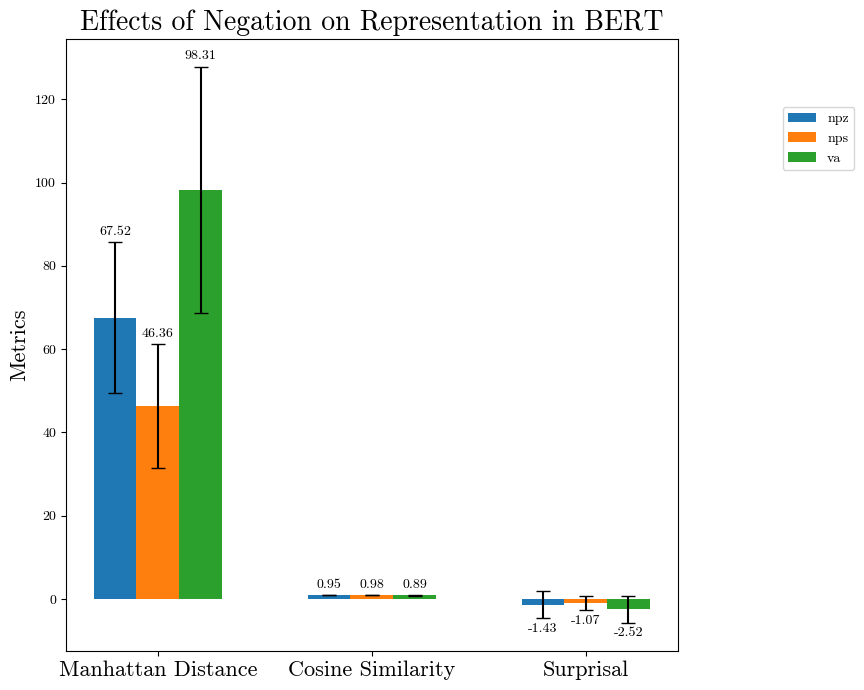

In [34]:
# surprisal for just the changed token

"""
def round_list(l, n):
    return [round(i, n) for i in l]

font = {'fontname':'Times New Roman'}
width = 0.2
sigfigs = 2
npz_means = round_list([67.51575, 0.950045185, -1.4320245972939893], sigfigs)
npz_stds = [18.120401, 0.029823769, 3.2228804224362784]
nps_means = round_list([46.35584, 0.9760152, -1.0666096799782265], sigfigs)
nps_stds = [14.957329, 0.017130245, 1.6926735818026295]
va_means = round_list([98.31098, 0.8917319, -2.5190417048525666], sigfigs)
va_stds = [29.545235, 0.07726601, 3.243318954775881]
types = ['Manhattan Distance', 'Cosine Similarity', 'Surprisal']
labels = ['npz', 'nps', 'va']
cmap = ['blue', 'orange', 'green']

x = np.arange(len(types))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, npz_means, width, yerr=npz_stds, capsize=5, label='npz')
rects2 = ax.bar(x, nps_means, width, yerr=nps_stds, capsize=5, label='nps')
rects3 = ax.bar(x + width, va_means, width, yerr=va_stds, capsize=5, label='va')

ax.set_ylabel('Metrics', fontsize=16)
ax.set_title('Effects of Negation on Representation in BERT', fontsize=20)
ax.set_xticks(x, types, fontsize=16)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

ax.legend(# How to specify the location of the legend. Think of the first two bb_to_anchor args as x, y coordinates of the lagend. 
         bbox_to_anchor=(0.3, 1.1, 1, -0.2), loc='upper right',
                   fontsize=10)
    

fig.set_size_inches(9, 7)

fig.tight_layout()
plt.show()
"""


In [ ]:
# comparisons between GPT2 and BERT
qualitative insights 
baselines: percentage 